# Анализ рынка недвижимости РФ

<b>Задача:</b> исследовать рынок недвижимости в РФ за представленный период, определить от каких признаков зависит стоимость объекта недвижимости, создать модель прогноза цены этого объекта. 

# Предобработка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('realty_18_21.csv')
df

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,81,3,13,14,2,60.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...
5477001,19739760,2021-05-01,3,1,8,17,4,93.2,13.8,11
5477002,12503160,2021-05-01,3,2,17,32,2,45.9,6.6,11
5477003,8800000,2021-05-01,2871,2,4,17,3,86.5,11.8,1
5477004,11831910,2021-05-01,3,1,8,33,2,52.1,18.9,11


In [3]:
#посмртрим общую информацию о детасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   region         int64  
 3   building_type  int64  
 4   level          int64  
 5   levels         int64  
 6   rooms          int64  
 7   area           float64
 8   kitchen_area   float64
 9   object_type    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 417.9+ MB


Как видим в столбце с датой стоит тип не тот, который нужем нам - сменим его позже. Все остальное пока что не вызывает проблем. 

In [5]:
#посмотрим уникальные значения в каждом столбце 
for i in list(df.columns):
    print(df[i].unique())

[ 6050000  8650000  4000000 ... 12503160 11831910 13316200]
['2018-02-19T00:00:00.000000000' '2018-02-27T00:00:00.000000000'
 '2018-02-28T00:00:00.000000000' ... '2021-04-29T00:00:00.000000000'
 '2021-04-30T00:00:00.000000000' '2021-05-01T00:00:00.000000000']
[ 2661    81  2871  2843     3  3106  2922  2900  2722  6171  3230  4417
  5282  5368  3446  5520  6817  9579  2604  1010  9648  7793 13919  2860
  3019  4982  5241  3870  3991  2359  9654  2072  8090  4007 11171 10160
  7873  2594  8509 11416 11991  2880  5178 13913  6309  5952  6543  2328
  5993  2484 13098  4240  5789  1901 14880 10201  1491  2885  5794  2528
  4374  4695  5143  6937  2806 14368  5736  7121  4086   821 10582  7896
  8640  5703  8894  4249  3153  4189  2814  7929 16705    69  4963 61888]
[1 3 4 2 5 0]
[ 8  5 12 13  4  1  2  9 10 25  7  6 16 17 14 11  3 18 15 23 21 20 22 19
 28 24 26 32 30 27 31 29 34 33 35 37 36 39 38]
[10 24  9 16 14  5 25 15 17  8  2  3 18  4 22 12 20  7 19  6 23 27  1 21
 11 28 13 36 26 33 34

В столбце rooms откуда-то взялось -2, скорее всего, это описка, поэтому изменим это. Так же в столбце с типом дома 2 - новостройка, в данных это обозначено 11, сменим на 2, чтобы не путаться. 

In [3]:
#изменим в столбце rooms -2 на 2
df['rooms'] = df['rooms'].replace({-2:2}, regex=True)
df['object_type'] = df['object_type'].replace({11:2}, regex=True)

In [4]:
#установим тему для графиков
sns.set_theme(style="whitegrid", palette='terrain_r')

Теперь проверим данные на выбросы по столбцу price:

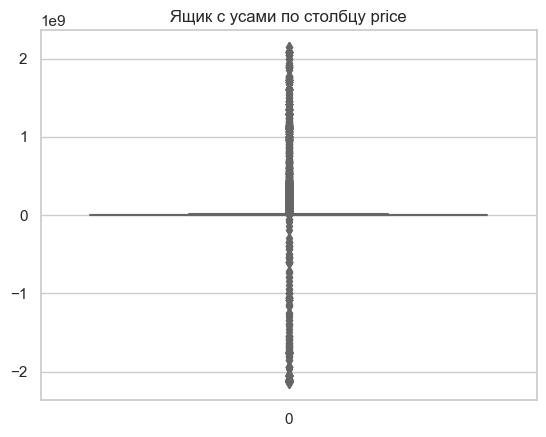

In [5]:
sns.boxplot(data=df['price']).set(title='Ящик с усами по столбцу price')
plt.show()

Судя по боксплоту, в столбце price имеются отрицательные значения (365 штук), такого быть не может, поэтому у нас имеются описки в данных, которые необходимо устранить. 

In [5]:
#убираем отрицательные значения стоимости, превращая их в положительное число
df['price'] = abs(df['price'])

In [6]:
#рассчитаем верхние и ниижние границы усов через квартили numpy
q75 = np.percentile(df['price'], 75)
q25 = np.percentile(df['price'], 25)
iqr = q75 - q25
ejection_h = q75 + iqr * 1.5
ejection_l = q25 - iqr * 1.5
print (ejection_h, ejection_l)

9089846.25 -2333907.75


In [7]:
#определим число выбросов - значений, которые находятся за пределами верхней и нижней границы. 
n_ejection = df['price'][(df['price'] > ejection_h) | (df['price'] < ejection_l)].count()
print('Число выбросов равно:', n_ejection)
print('Доля выбросов в детасете:', round((n_ejection/df['price'].count()*100), 2), '%')

Число выбросов равно: 432622
Доля выбросов в детасете: 7.9 %


Да, 8% это достаточно весомое значение, но не такое огромное для 5 с лишним миллионов строк, можно было бы аккуратнее удалить лишь 0,16% данных через три сигмы, но я решила пожалеть ноутбук и более агрессивно удалить выбросы. 

In [8]:
good_df = df[(df['price'] < ejection_h) & (df['price'] > ejection_l)]
good_df = good_df.reset_index(drop=True)
good_df

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,2843,4,12,16,2,38.0,5.0,2
4,5450000,2018-03-01,81,3,13,14,2,60.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...
5044379,6400000,2021-05-01,81,3,4,17,3,82.0,10.6,1
5044380,7200000,2021-05-01,3446,2,2,3,2,59.0,22.3,2
5044381,4900000,2021-05-01,2661,1,2,5,1,31.0,6.0,1
5044382,9000000,2021-05-01,2900,3,4,5,4,178.0,20.0,1


ЖК РФ устанавливает и минимальную норму жилой площади - 6 кв. м на одного человека, поэтому не будем нарушать закон и отбросим несоответствующие предложения недвижимости. 

In [9]:
good_df = good_df[good_df['area'] > 6]

In [10]:
good_df.duplicated().sum()
#удалим дубликаты из детасета
good_df = good_df.drop_duplicates()
good_df

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,2843,4,12,16,2,38.0,5.0,2
4,5450000,2018-03-01,81,3,13,14,2,60.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...
5044379,6400000,2021-05-01,81,3,4,17,3,82.0,10.6,1
5044380,7200000,2021-05-01,3446,2,2,3,2,59.0,22.3,2
5044381,4900000,2021-05-01,2661,1,2,5,1,31.0,6.0,1
5044382,9000000,2021-05-01,2900,3,4,5,4,178.0,20.0,1


В ходе предобработки я исправила некоторые ошибки в данных, типа отрицательной стоимости квартир, удалила выбросы, дубликаты и подозрительно маленькие предложения площади квартир. Теперь мы можем перейти к дальнейшему исследованию этих данных. 

# 1. Восстановите пропуски в столбце kitchen_area.

«Площадь кухни зависит как от общей площади квартиры, так и от количества комнат», – комментирует Дмитрий Михалев, руководитель службы по работе с госорганами «СПб Реновация».

По этим причнам, заполнение средним/медианой по столбцу не имеет смысла, поскольку на площадь кухни влияет несколько факторов. Нам нужны многомерные способы заполнения пропусков. Один из них - алгоритм MICE. <br>



In [12]:
#посмотрим количество пропусков по этому столбцу 
good_df[good_df['kitchen_area'].isna()]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
19,1650000,2018-03-16,2843,3,5,5,2,51.00,NaN,1
40,4400000,2018-04-14,81,3,11,14,2,54.00,NaN,1
73,2980000,2018-06-04,4417,1,7,9,2,52.00,NaN,1
107,2900000,2018-07-12,81,3,2,9,1,37.50,NaN,1
129,5800000,2018-07-31,2661,2,6,14,1,47.10,NaN,1
...,...,...,...,...,...,...,...,...,...,...
5044266,4341900,2021-05-01,9654,3,23,25,2,52.95,NaN,2
5044310,7000000,2021-05-01,2604,3,3,4,2,57.00,NaN,1
5044316,3200000,2021-05-01,2604,3,1,5,1,47.90,NaN,1
5044327,3247500,2021-05-01,6543,0,7,12,-1,43.30,NaN,2


Перед заполнением пропусков посмотрим на изначальные статистики столбца kitchen_area и плотность его распределения без учета этих пропусков, чтобы потом сделать вывод о качестве заполнения пропусков. 

In [12]:
good_df['kitchen_area'].describe()

count    4.576732e+06
mean     1.015751e+01
std      9.930133e+00
min      1.000000e-02
25%      7.000000e+00
50%      9.000000e+00
75%      1.200000e+01
max      9.999000e+03
Name: kitchen_area, dtype: float64

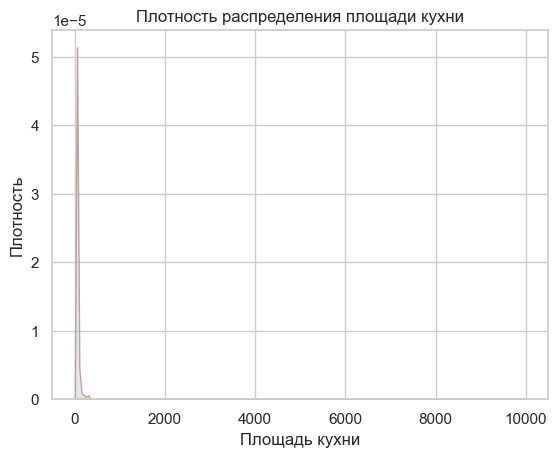

In [13]:
sns.kdeplot(good_df['kitchen_area'], fill=True).set(title='Плотность распределения площади кухни',
                                                                 xlabel='Площадь кухни', 
                                                                 ylabel='Плотность')
plt.show()

In [11]:
#создадим список с датами, так как их не получиться загнать в алгоритмя для заполнения пропусков
list_11 = list(good_df['date'])

In [12]:
#создаем срез датасета
a = good_df[['price', 'region', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type']]

In [13]:
# сделаем копию датафрейма
good_copy = a.copy()

In [14]:
# создадим объект класса StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
 
# стандартизируем данные и сразу поместим их в датафрейм
good_copy = pd.DataFrame(scaler.fit_transform(good_copy), columns = good_copy.columns)

In [15]:
# создадим объект класса IterativeImputer и укажем необходимые параметры
good_imputer = IterativeImputer(initial_strategy = 'median', # вначале заполним пропуски медианой
                                estimator = LinearRegression(), # в качестве модели используем линейную регрессию
                                random_state = 42 # добавим точку отсчета
                                )
 
# используем метод .fit_transform() для заполнения пропусков в датасете good_copy
good_copy = good_imputer.fit_transform(good_copy)
 
# вернем данные к исходному масштабу и округлим столбец kitchen_area
good_copy = pd.DataFrame(scaler.inverse_transform(good_copy), columns = a.columns)
good_copy['kitchen_area'] = good_copy['kitchen_area'].round(1)
good_copy['region'] = good_copy['region'].round(0)
good_copy['level'] = good_copy['level'].round(0)
good_copy['levels'] = good_copy['levels'].round(0)
good_copy['rooms'] = good_copy['rooms'].round(0)
good_copy.head(7)

,price,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000.0,2661.0,1.0,8.0,10.0,3.0,82.6,10.8,1.0
1,8650000.0,81.0,3.0,5.0,24.0,2.0,69.1,12.0,1.0
2,4000000.0,2871.0,1.0,5.0,9.0,3.0,66.0,10.0,1.0
3,1850000.0,2843.0,4.0,12.0,16.0,2.0,38.0,5.0,2.0
4,5450000.0,81.0,3.0,13.0,14.0,2.0,60.0,10.0,1.0
5,3300000.0,81.0,1.0,4.0,5.0,1.0,32.0,6.0,1.0
6,4704280.0,3.0,2.0,1.0,25.0,1.0,31.7,6.0,2.0


In [18]:
#проверка
good_copy[good_copy['kitchen_area'].isna()]

,price,region,building_type,level,levels,rooms,area,kitchen_area,object_type


In [19]:
#посмотрим описательные статистики после заполнения пропусков
good_copy['kitchen_area'].describe()

count    4.809206e+06
mean     1.015701e+01
std      9.703898e+00
min      0.000000e+00
25%      7.000000e+00
50%      9.100000e+00
75%      1.200000e+01
max      9.999000e+03
Name: kitchen_area, dtype: float64

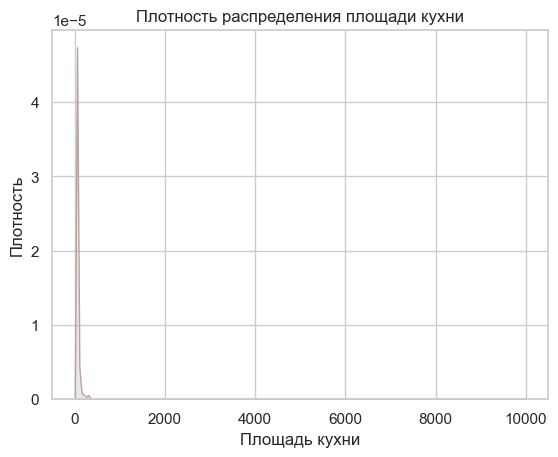

In [22]:
#построим теперь плотность распределения после заполнения пропусков
sns.kdeplot(good_copy['kitchen_area'], fill=True).set(title='Плотность распределения площади кухни',
                                                                 xlabel='Площадь кухни', 
                                                                 ylabel='Плотность')
plt.show()

In [16]:
#вернем дату нашему датафрейму
good_copy['date'] = list_11
good_copy

,price,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date
0,6050000.0,2661.0,1.0,8.0,10.0,3.0,82.6,10.8,1.0,2018-02-19
1,8650000.0,81.0,3.0,5.0,24.0,2.0,69.1,12.0,1.0,2018-02-27
2,4000000.0,2871.0,1.0,5.0,9.0,3.0,66.0,10.0,1.0,2018-02-28
3,1850000.0,2843.0,4.0,12.0,16.0,2.0,38.0,5.0,2.0,2018-03-01
4,5450000.0,81.0,3.0,13.0,14.0,2.0,60.0,10.0,1.0,2018-03-01
...,...,...,...,...,...,...,...,...,...,...
4809201,6400000.0,81.0,3.0,4.0,17.0,3.0,82.0,10.6,1.0,2021-05-01
4809202,7200000.0,3446.0,2.0,2.0,3.0,2.0,59.0,22.3,2.0,2021-05-01
4809203,4900000.0,2661.0,1.0,2.0,5.0,1.0,31.0,6.0,1.0,2021-05-01
4809204,9000000.0,2900.0,3.0,4.0,5.0,4.0,178.0,20.0,1.0,2021-05-01


Как можно заметить, форма распределения и значимые статистики после заполнения пропусков сильно не изменились, значит, заполнение прошло удачным образом. 

# 2. Добавьте информацию из датасета region.csv.

In [17]:
#загружаем датасет
df_1 = pd.read_csv('region.csv')
df_1.columns = ['region', 'reg_name']
df_1

,region,reg_name
0,2661,Санкт-Петербург
1,3446,Ленинградская область
2,3,Москва
3,81,Московская область
4,2843,Краснодарский край
...,...,...
78,16705,Магаданская область
79,69,Еврейская автономная область
80,4963,Приморский край
81,1901,Сахалинская область


В ходе знакомства с этим датасетом выяснилось, что водной строчке у нас есть два кода для одного региона, исправим это.

In [18]:
df_1[df_1['region'] == '7873, 6937']

,region,reg_name
36,"7873, 6937",Республика Крым


In [19]:
#перезапишем значение одного кода
df_1['region'] = df_1['region'].replace({'7873, 6937':'7873'}, regex=True)

In [20]:
#добавим значение другого кода для Крыма новой строкой в датасет
g = {'region':'6937','reg_name':'Республика Крым'}
df_1 = df_1.append(g, ignore_index=True)
df_1

C:\Users\Настя\AppData\Local\Temp\ipykernel_29752\2465179290.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_1 = df_1.append(g, ignore_index=True)


,region,reg_name
0,2661,Санкт-Петербург
1,3446,Ленинградская область
2,3,Москва
3,81,Московская область
4,2843,Краснодарский край
...,...,...
79,69,Еврейская автономная область
80,4963,Приморский край
81,1901,Сахалинская область
82,61888,Ненецкий автономный округ


In [21]:
#сменим тип данных
df_1['region'] = df_1['region'].astype('int')

In [22]:
#теперь найдем те, что есть в good_df, но их нет в df_1
list_1 = list(good_copy['region'].unique())
list_2 = list(df_1['region'].unique())
a = set(list_1) - set(list_2)

In [23]:
a

set()

Таких значений кодов не было найдено, значит, мы можем спокойно объединять эти два датасета без потери данных

In [24]:
#объединим датасеты по столбцу region
good_df_2 = good_copy.merge(df_1, on='region')
good_df_2

,price,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date,reg_name
0,6050000.0,2661.0,1.0,8.0,10.0,3.0,82.6,10.8,1.0,2018-02-19,Санкт-Петербург
1,3600000.0,2661.0,1.0,2.0,5.0,1.0,31.1,6.0,1.0,2018-03-04,Санкт-Петербург
2,3200000.0,2661.0,1.0,7.0,9.0,1.0,31.0,7.0,1.0,2018-04-10,Санкт-Петербург
3,6500000.0,2661.0,3.0,3.0,3.0,3.0,89.0,10.0,1.0,2018-04-23,Санкт-Петербург
4,6300000.0,2661.0,3.0,5.0,5.0,2.0,99.9,14.5,1.0,2018-04-28,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...
4809201,3000000.0,61888.0,5.0,2.0,2.0,2.0,57.0,10.0,1.0,2018-11-29,Ненецкий автономный округ
4809202,1400000.0,61888.0,3.0,3.0,3.0,1.0,18.6,4.0,1.0,2018-11-29,Ненецкий автономный округ
4809203,6000000.0,61888.0,3.0,5.0,5.0,2.0,64.3,16.3,1.0,2018-11-30,Ненецкий автономный округ
4809204,3500000.0,61888.0,2.0,1.0,3.0,2.0,59.7,10.2,1.0,2018-11-30,Ненецкий автономный округ


In [25]:
#сменим тип данных для столбца date
good_df_2['date'] = pd.to_datetime(good_df_2['date'], format='%Y-%m-%d')

Также случайным образом заметила, что в датасете есть строки, в которых площадь кухни превышает площадь всей территории. Такого быть не может, поэтому это описки в данных, которые стоит удалить для корректности исследования.

In [26]:
# удалим такие строки
good_df = good_df_2[good_df_2['kitchen_area'] <= good_df_2['area']]
good_df

,price,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date,reg_name
0,6050000.0,2661.0,1.0,8.0,10.0,3.0,82.6,10.8,1.0,2018-02-19,Санкт-Петербург
1,3600000.0,2661.0,1.0,2.0,5.0,1.0,31.1,6.0,1.0,2018-03-04,Санкт-Петербург
2,3200000.0,2661.0,1.0,7.0,9.0,1.0,31.0,7.0,1.0,2018-04-10,Санкт-Петербург
3,6500000.0,2661.0,3.0,3.0,3.0,3.0,89.0,10.0,1.0,2018-04-23,Санкт-Петербург
4,6300000.0,2661.0,3.0,5.0,5.0,2.0,99.9,14.5,1.0,2018-04-28,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...
4809201,3000000.0,61888.0,5.0,2.0,2.0,2.0,57.0,10.0,1.0,2018-11-29,Ненецкий автономный округ
4809202,1400000.0,61888.0,3.0,3.0,3.0,1.0,18.6,4.0,1.0,2018-11-29,Ненецкий автономный округ
4809203,6000000.0,61888.0,3.0,5.0,5.0,2.0,64.3,16.3,1.0,2018-11-30,Ненецкий автономный округ
4809204,3500000.0,61888.0,2.0,1.0,3.0,2.0,59.7,10.2,1.0,2018-11-30,Ненецкий автономный округ


Удалим выбросы по площадям кухни и по площади всей квартиры

In [27]:
mu = good_df['kitchen_area'].mean() # среднее значение
sigma = good_df['kitchen_area'].std() # стандартное отклонение
# рассчитваем значение правого уса
ej_h = mu + 3 * sigma
ej_l = mu - 3 * sigma
# выводим значение
print(ej_h, ej_l)

26.225527768125215 -5.965363928378697


In [28]:
#определим число выбросов - значений, которые находятся за пределами верхней и нижней границы. 
n_ejection =  good_df['kitchen_area'][( good_df['kitchen_area'] > ej_h) | ( good_df['kitchen_area'] < ej_l)].count()
print('Число выбросов равно:', n_ejection)
print('Доля выбросов в детасете:', round((n_ejection/ good_df['kitchen_area'].count()*100), 2), '%')

Число выбросов равно: 46922
Доля выбросов в детасете: 0.98 %


In [29]:
good_df = good_df[(good_df['kitchen_area'] < ej_h) & (good_df['kitchen_area'] > ej_l)]
good_df = good_df.reset_index(drop=True)
good_df

,price,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date,reg_name
0,6050000.0,2661.0,1.0,8.0,10.0,3.0,82.6,10.8,1.0,2018-02-19,Санкт-Петербург
1,3600000.0,2661.0,1.0,2.0,5.0,1.0,31.1,6.0,1.0,2018-03-04,Санкт-Петербург
2,3200000.0,2661.0,1.0,7.0,9.0,1.0,31.0,7.0,1.0,2018-04-10,Санкт-Петербург
3,6500000.0,2661.0,3.0,3.0,3.0,3.0,89.0,10.0,1.0,2018-04-23,Санкт-Петербург
4,6300000.0,2661.0,3.0,5.0,5.0,2.0,99.9,14.5,1.0,2018-04-28,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...
4760941,3000000.0,61888.0,5.0,2.0,2.0,2.0,57.0,10.0,1.0,2018-11-29,Ненецкий автономный округ
4760942,1400000.0,61888.0,3.0,3.0,3.0,1.0,18.6,4.0,1.0,2018-11-29,Ненецкий автономный округ
4760943,6000000.0,61888.0,3.0,5.0,5.0,2.0,64.3,16.3,1.0,2018-11-30,Ненецкий автономный округ
4760944,3500000.0,61888.0,2.0,1.0,3.0,2.0,59.7,10.2,1.0,2018-11-30,Ненецкий автономный округ


In [30]:
mu = good_df['area'].mean() # среднее значение
sigma = good_df['area'].std() # стандартное отклонение
# рассчитваем значение правого уса
ej_h = mu + 3 * sigma
ej_l = mu - 3 * sigma
# выводим значение
print(ej_h, ej_l)

131.89424255805528 -30.77886358910127


In [31]:
good_df = good_df[(good_df['area'] < ej_h) & (good_df['area'] > ej_l)]
good_df = good_df.reset_index(drop=True)
good_df

,price,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date,reg_name
0,6050000.0,2661.0,1.0,8.0,10.0,3.0,82.6,10.8,1.0,2018-02-19,Санкт-Петербург
1,3600000.0,2661.0,1.0,2.0,5.0,1.0,31.1,6.0,1.0,2018-03-04,Санкт-Петербург
2,3200000.0,2661.0,1.0,7.0,9.0,1.0,31.0,7.0,1.0,2018-04-10,Санкт-Петербург
3,6500000.0,2661.0,3.0,3.0,3.0,3.0,89.0,10.0,1.0,2018-04-23,Санкт-Петербург
4,6300000.0,2661.0,3.0,5.0,5.0,2.0,99.9,14.5,1.0,2018-04-28,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...
4748352,3000000.0,61888.0,5.0,2.0,2.0,2.0,57.0,10.0,1.0,2018-11-29,Ненецкий автономный округ
4748353,1400000.0,61888.0,3.0,3.0,3.0,1.0,18.6,4.0,1.0,2018-11-29,Ненецкий автономный округ
4748354,6000000.0,61888.0,3.0,5.0,5.0,2.0,64.3,16.3,1.0,2018-11-30,Ненецкий автономный округ
4748355,3500000.0,61888.0,2.0,1.0,3.0,2.0,59.7,10.2,1.0,2018-11-30,Ненецкий автономный округ


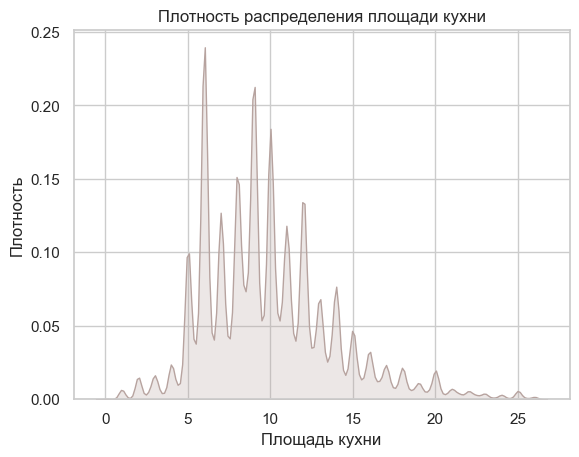

In [33]:
sns.kdeplot(good_df['kitchen_area'], fill=True).set(title='Плотность распределения площади кухни',
                                                                 xlabel='Площадь кухни', 
                                                                 ylabel='Плотность')
plt.show()

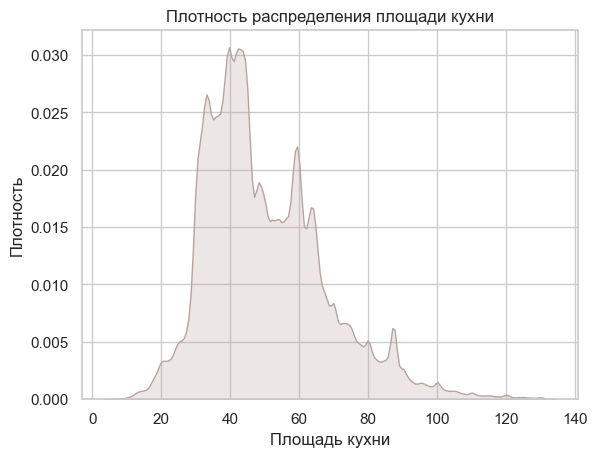

In [34]:
sns.kdeplot(good_df['area'], fill=True).set(title='Плотность распределения площади кухни',
                                                                 xlabel='Площадь кухни', 
                                                                 ylabel='Плотность')
plt.show()

Датасеты объединены - теперь можем начинать наше исследование. 

# 3. Исследуйте рынок недвижимости в РФ за представленный период. Величина исследования - цена за м2.

In [32]:
#зададим размер графиков
plt.rcParams['figure.figsize'] = (10, 6)

In [33]:
#вытащим из даты в отдельный столбец год
good_df['year'] = good_df['date'].dt.year
#вытащим из даты покупки  в отдельный столбец месяц
good_df['month'] = good_df['date'].dt.month
#склеим месяц и год в отдельный столбец месяц для дальнейщего исследования
good_df['month_year'] = good_df['month'].astype('str') +'.'+ good_df['year'].astype('str')

In [34]:
#введем величину исследования - цену за 1 м^2
good_df['price_1_m'] = round(good_df['price'] / good_df['area'], 2)

In [35]:
#создадим сводную таблицу с данными о размере средней цены м^2 по годам
df_year = good_df.pivot_table(index='year', aggfunc='mean',values='price_1_m').sort_values (by = 'year', ascending=True).reset_index()
df_year

,year,price_1_m
0,2018,60452.436899
1,2019,63236.685819
2,2020,74073.965071
3,2021,86940.195222


In [36]:
df_year['year'] = df_year['year'].astype('str')

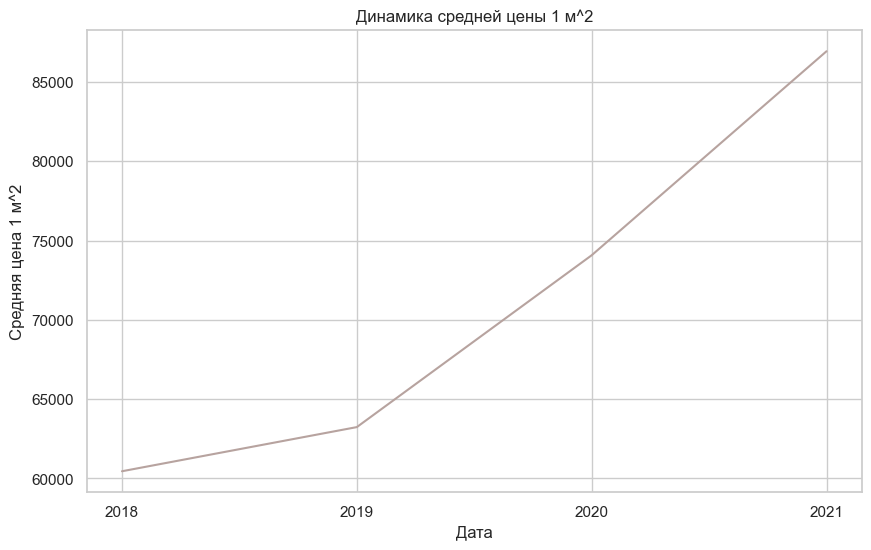

In [39]:
#построим линейный график по этой сводной таблице
sns.lineplot(data=df_year, x='year', y='price_1_m').set(title='Динамика средней цены 1 м^2',
                                                                 xlabel='Дата', 
                                                                 ylabel='Средняя цена 1 м^2')
plt.show()

Как мы можем заметить, средняя цена 1 м^2 имеет положительную динамику за исследуемый период. Особенно резкий рост стоимости пришелся на 2019 год. Причинами этого могли стать события, пришедшиеся как раз на этот год: повышение ставок НДС (с 18% до 20%), низкие ставки по ипотечному кредитованию, резкий рост страховых взносов, изменения в 214-ФЗ. 

In [37]:
#изменим формат столбца Month_Year на формат для времени
good_df['month_year'] = pd.to_datetime(good_df['month_year'], format='%m.%Y')

In [43]:
#создадим сводную таблицу с данными о размере средней цены м^2 по месяцу и году
df_year_month = good_df.pivot_table(index='month_year', aggfunc='mean',values='price_1_m').sort_values (by = 'month_year', ascending=True).reset_index()
df_year_month

,month_year,price_1_m
0,2018-02-01,86343.836667
1,2018-03-01,79668.590800
2,2018-04-01,66951.925600
3,2018-05-01,55913.074118
4,2018-06-01,66307.061429
5,2018-07-01,61932.539487
6,2018-08-01,67775.987534
7,2018-09-01,61244.522649
8,2018-10-01,59669.731239
9,2018-11-01,59529.617093


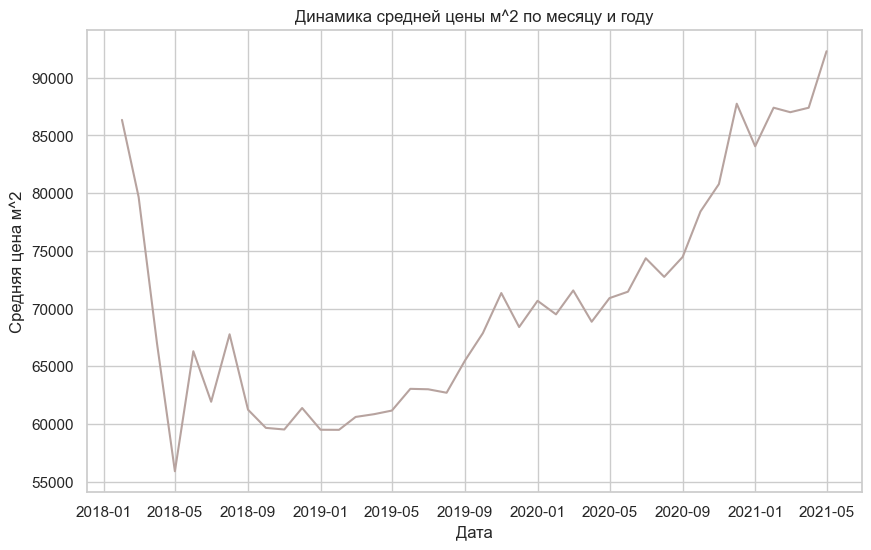

In [44]:
#построим линейный график по этой сводной таблице
sns.lineplot(data=df_year_month, x='month_year', y='price_1_m').set(title='Динамика средней цены м^2 по месяцу и году',
                                                                 xlabel='Дата', 
                                                                 ylabel='Средняя цена м^2')
plt.show()

Можно заметить, что укрупнение интервалов до месяцев дало нам возможность рассмотреть колебания цены внутри каждого года, чтобы более детально изучить динамику данного показателя. Можем заметить, что значительно просели цены к маю 2018 года, а уже к сентябрю 2018 цены подросли, с этого времени динамика м^2 имеет положительный тренд. Однако, нужно сказать, что досчтичь уровня цен на 1 м^2, который был зафиксирован в январе 2018 году удалось лишь осенью (октябрь-декабрь) 2021 года, когда цены значительно подскочили относительно сентября этого же года. Это могло быть связано с введением льготной ипотеки, которое в свою очерель породило резкий рост спроса на недвижимость и, естественно, подняло цены на нее. 

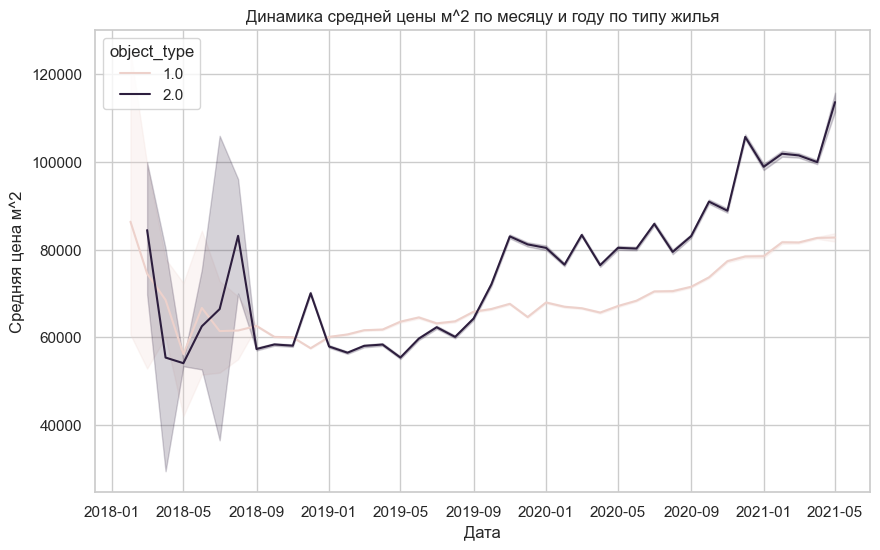

In [58]:
sns.lineplot(data=good_df, x='month_year', y='price_1_m', hue='object_type').set(title=f'Динамика средней цены м^2 по месяцу и году по типу жилья',
                                                                 xlabel='Дата', 
                                                                 ylabel='Средняя цена м^2')
plt.show()

Также я построила график динамики средней цены 1 м^2 для новостроек и вторичного жилья. Уровень цен для новостроек (синяя линия) будет лежать выше, чем уровень цен на вторичное жилье. Можно сказать, что динамика цен на вторичном рынке тоже имеет положительную тенденцию, однако она более плавная и равномерная, чем стоимость метра в новостройке. Его динамика тоже положительная, нокуда более "рваная" и резкая. В 2019 году цены на новостройки оказались в среднем ниже, чем цены на вторичное жилье. 

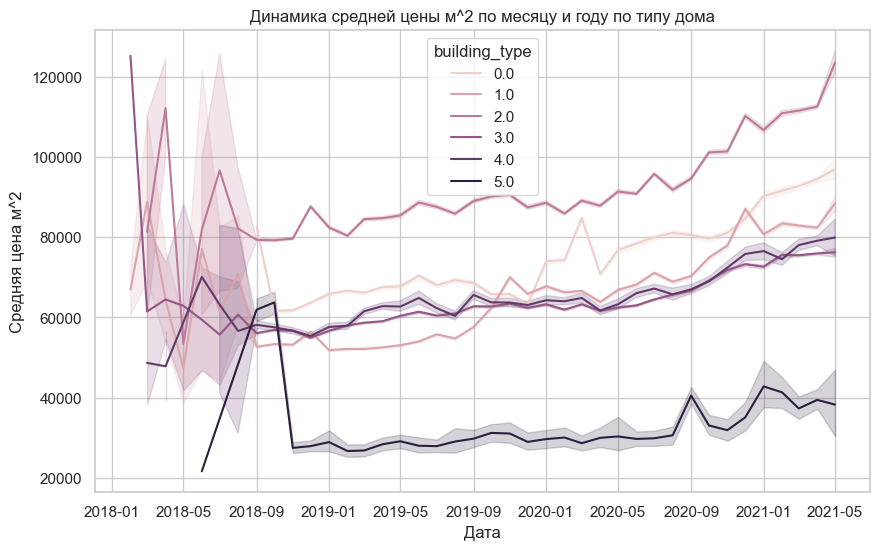

In [60]:
sns.lineplot(data=good_df, x='month_year', y='price_1_m', hue='building_type').set(title=f'Динамика средней цены м^2 по месяцу и году по типу дома',
                                                                 xlabel='Дата', 
                                                                 ylabel='Средняя цена м^2')
plt.show()

Напомню типы домов: 0 - Другое; 1 - Панельный; 2 - Кирпично-монолитный; 3 - Кирпичный; 4 - Блочный; 5 - Деревянный. <br>

Мы можем заметить, что самый высокий уровень цен за метр квадратный у кирпично-монолитных домов, самый низкий - у деревянных. В мае 2018 года значительно просели цены на кирпично-монолитные дома и на панельные. В целом у всех типов домов динамика скачкоообразная с переменными спадами и возрастаниями, но они все, как и говорилось ранее, растут в общей динамике. 

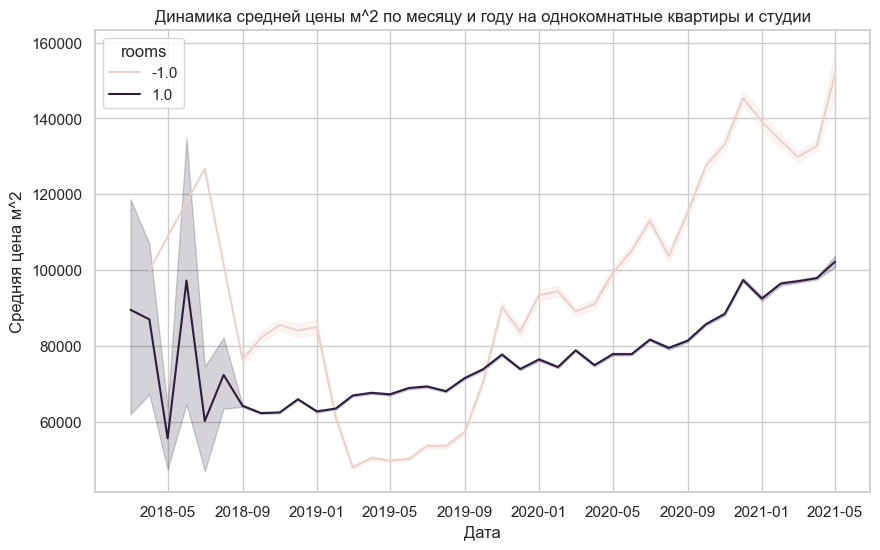

In [41]:
sns.lineplot(data=good_df[(good_df['rooms'] == -1) | (good_df['rooms'] == 1)], x='month_year', y='price_1_m', hue='rooms').set(title=f'Динамика средней цены м^2 по месяцу и году на однокомнатные квартиры и студии',
                                                                 xlabel='Дата', 
                                                                 ylabel='Средняя цена м^2')
plt.show()

По рисунку видно, что студии, кроме провала в 2019 году, были дороже однокомнатных квартир. Кроме того, после введения льготной ипотеки (конец 2019 - начало 2020), их цена бешеными темпами взлетела и продожает расти сильнее, чем стоимость квадратного метра в однокомнатных квартирах.

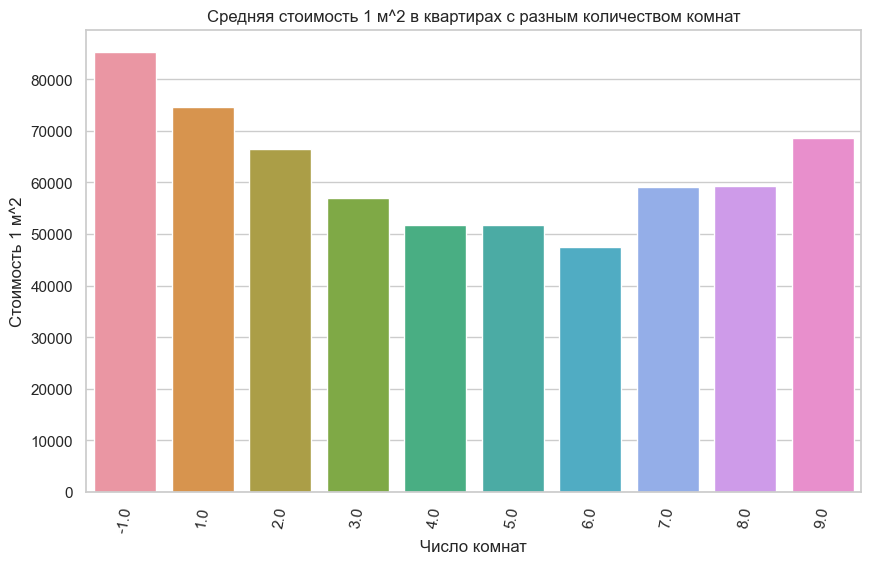

In [42]:
#построим столбчатую диаграмму 
sns.barplot(data=good_df.pivot_table(index='rooms', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=True).reset_index().head(10), y='price_1_m', x='rooms').set(title='Средняя стоимость 1 м^2 в квартирах с разным количеством комнат',
                                                                               ylabel='Стоимость 1 м^2',
                                                                               xlabel='Число комнат')
plt.xticks(rotation=80)
plt.show()

Мы видим, что в малокомнатных квартирах стоимость квадратного метра выше, чем многочисленных. Кроме того, самый дешевый квадратный метр в шестикомнаных квартирах, после чего его цена растет у стоимость метра в трехкомнатной и семикрмнатной квартирах приктически равны друг другу, как в девятикоматной равно метру в двухкомнатной.  

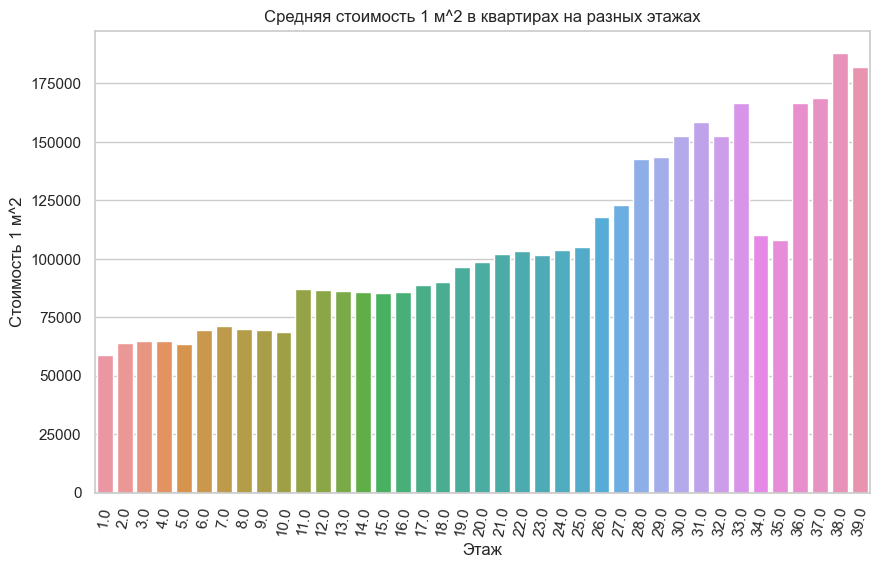

In [43]:
#построим столбчатую диаграмму 
sns.barplot(data=good_df.pivot_table(index='level', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=True).reset_index(), y='price_1_m', x='level').set(title='Средняя стоимость 1 м^2 в квартирах на разных этажах',
                                                                               ylabel='Стоимость 1 м^2',
                                                                               xlabel='Этаж')
plt.xticks(rotation=80)
plt.show()

Мы видим, что на первых этажах средняя цена 1 м^2 ниже, чем на остальных, кроме того, проседание можно заметить для 34 и для 35 этажей, возможно это связано с тем, что они в большинстве домов последние и не имеют видового преимущства. Остальные же (36, 37, 38, 39) возможно как раз такие обладают видовыми квартирами, цен на которые, естественно, в разы выше. Кроме того в квартирах на последних этажах могут быть высокие потолки, терассы и тд. 

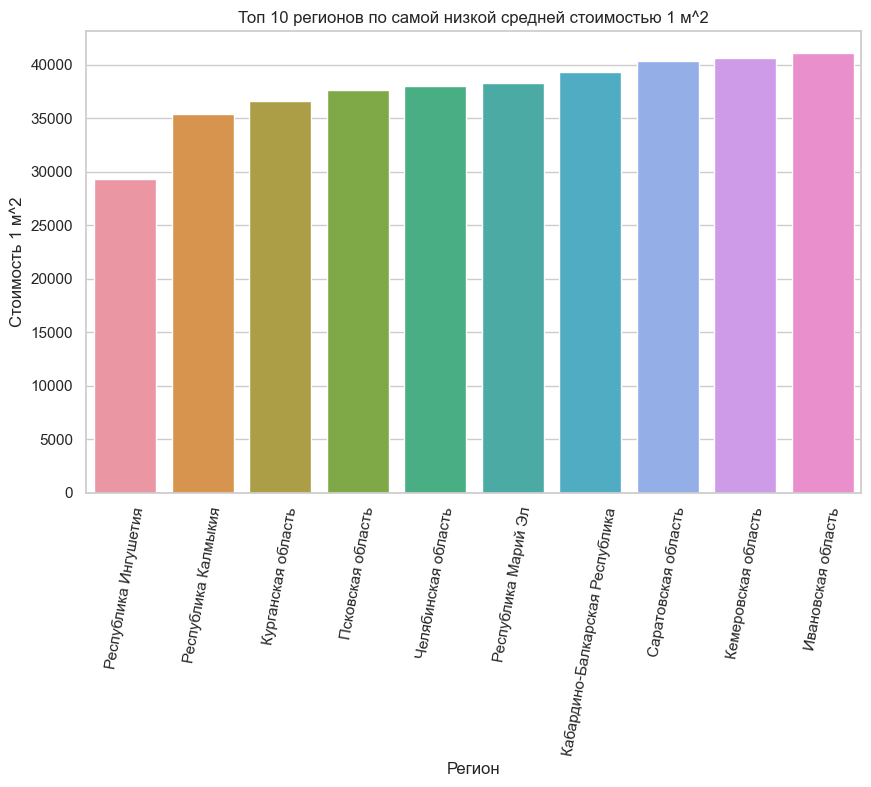

In [45]:
#построим столбчатую диаграмму 
sns.barplot(data=good_df.pivot_table(index='reg_name', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=True).head(10).reset_index(), y='price_1_m', x='reg_name').set(title='Топ 10 регионов по самой низкой средней стоимостью 1 м^2',
                                                                               ylabel='Стоимость 1 м^2',
                                                                               xlabel='Регион')
plt.xticks(rotation=80)
plt.show()

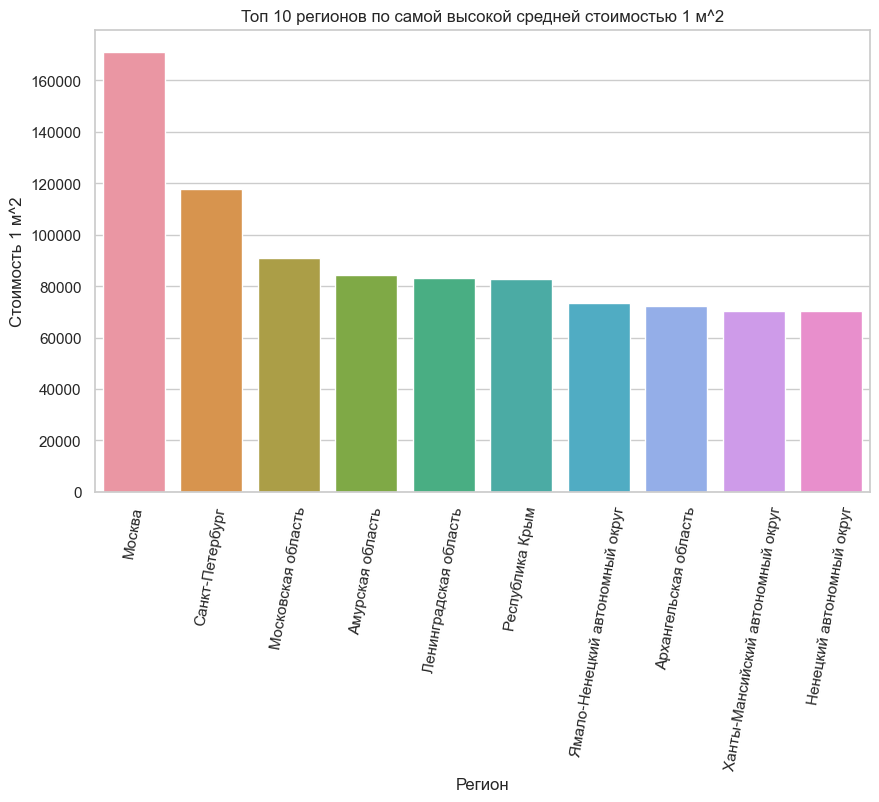

In [48]:
#построим столбчатую диаграмму 
sns.barplot(data=good_df.pivot_table(index='reg_name', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=False).reset_index().head(10), y='price_1_m', x='reg_name').set(title='Топ 10 регионов по самой высокой средней стоимостью 1 м^2',
                                                                               ylabel='Стоимость 1 м^2',
                                                                               xlabel='Регион')
plt.xticks(rotation=80)
plt.show()

Как можно заметить по графикам, самая низкая стоимость 1 м^2 в Республике Ингушетия, а закрывает десятку регионов с самой низкой ценой Республика Дагестан. <br>

Очевидно, что самая дорогая недвижимость в крупных городах-миллионниках - Москва и Санкт-Петербург, за ними следуют Московская и Ленинградская области. 

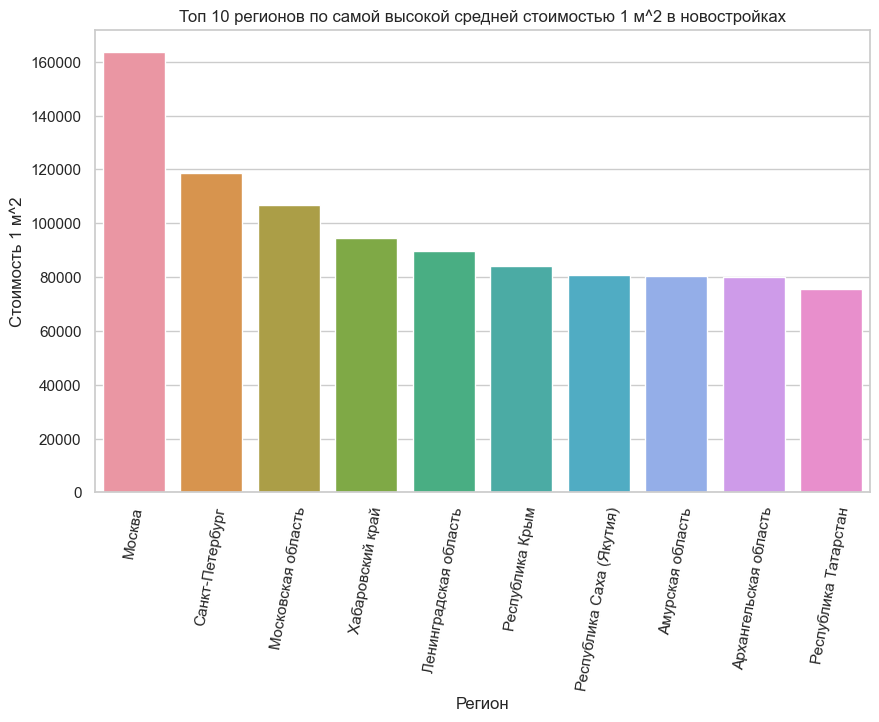

In [48]:
#построим столбчатую диаграмму 
sns.barplot(data=good_df[good_df['object_type'] == 2].pivot_table(index='reg_name', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=False).reset_index().head(10), y='price_1_m', x='reg_name').set(title='Топ 10 регионов по самой высокой средней стоимостью 1 м^2 в новостройках',
                                                                               ylabel='Стоимость 1 м^2',
                                                                               xlabel='Регион')
plt.xticks(rotation=80)
plt.show()

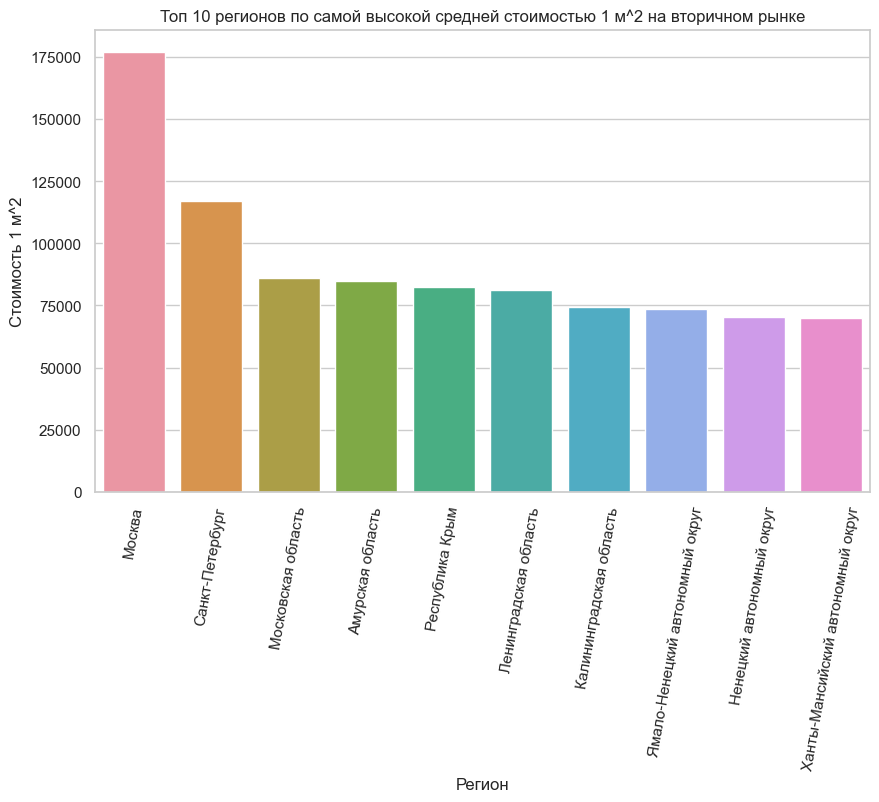

In [49]:
#построим столбчатую диаграмму 
sns.barplot(data=good_df[good_df['object_type'] == 1].pivot_table(index='reg_name', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=False).reset_index().head(10), y='price_1_m', x='reg_name').set(title='Топ 10 регионов по самой высокой средней стоимостью 1 м^2 на вторичном рынке',
                                                                               ylabel='Стоимость 1 м^2',
                                                                               xlabel='Регион')
plt.xticks(rotation=80)
plt.show()

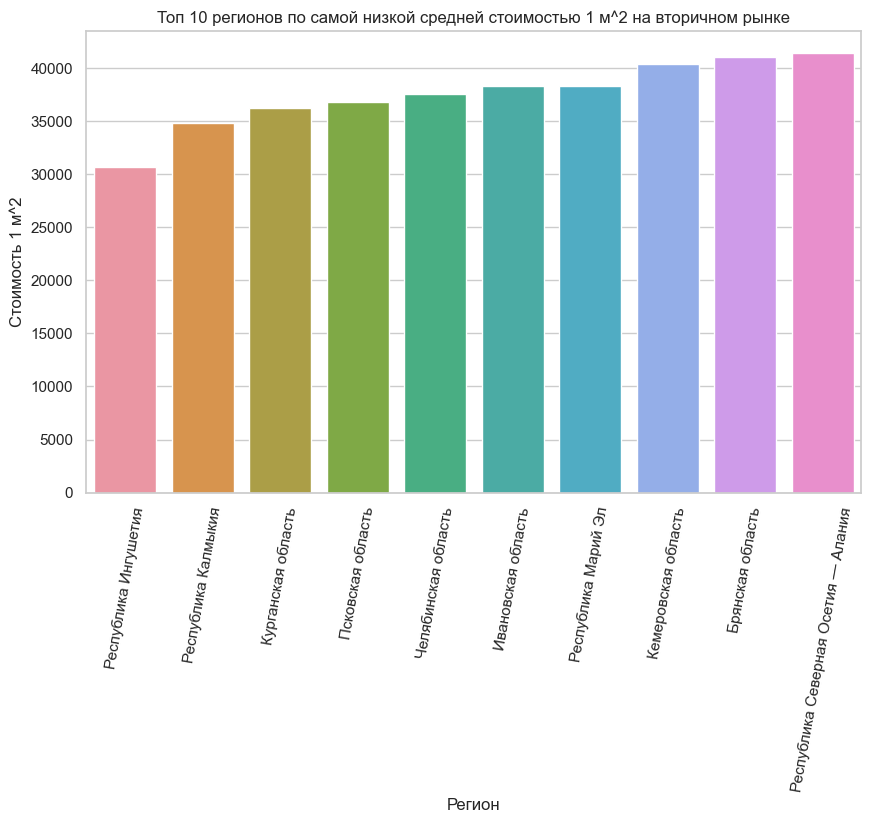

In [50]:
#построим столбчатую диаграмму 
sns.barplot(data=good_df[good_df['object_type'] == 1].pivot_table(index='reg_name', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=True).reset_index().head(10), y='price_1_m', x='reg_name').set(title='Топ 10 регионов по самой низкой средней стоимостью 1 м^2 на вторичном рынке',
                                                                               ylabel='Стоимость 1 м^2',
                                                                               xlabel='Регион')
plt.xticks(rotation=80)
plt.show()

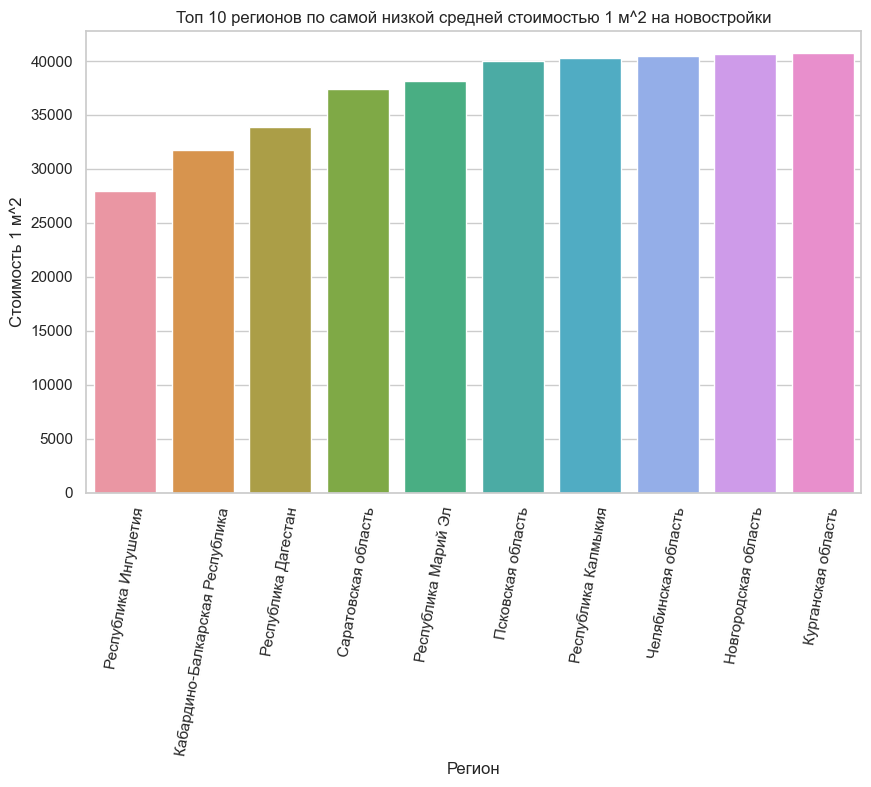

In [51]:
#построим столбчатую диаграмму 
sns.barplot(data=good_df[good_df['object_type'] == 2].pivot_table(index='reg_name', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=True).reset_index().head(10), y='price_1_m', x='reg_name').set(title='Топ 10 регионов по самой низкой средней стоимостью 1 м^2 на новостройки',
                                                                               ylabel='Стоимость 1 м^2',
                                                                               xlabel='Регион')
plt.xticks(rotation=80)
plt.show()

Рассмотрение топ-10 с разбивкой по типу жилья помогает лишь отследить изменения в учсатниках топа, но него лидерах: так самые высокие цены на любые типы жилья остаются в Петербурге и Москве, самые низкие - в Республике Ингушетии. 

In [46]:
good_df['reg_name'].value_counts().head()

Новосибирская область    835556
Краснодарский край       599719
Московская область       467790
Санкт-Петербург          346854
Свердловская область     223164
Name: reg_name, dtype: int64

Я решила посмотреть по каким регионам было предоставлено больше объявлений о продаже недвижимости, чтобы посмотреть динамику отдельно по ним. В лидерах оказалась Новосибирская область, Санкт-Петербург попал в пятерку лидеров. 

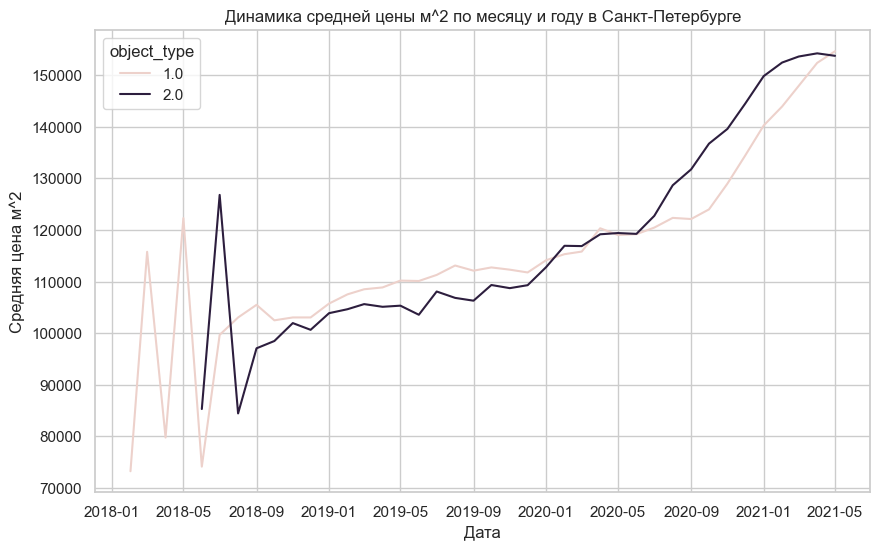

In [52]:
#создадим сводную таблицу с данными о размере средней цены м^2 по месяцу и году для Санкт-Петербурга
df_year_month_spb = good_df[good_df['reg_name'] == 'Санкт-Петербург'].pivot_table(index=['month_year', 'object_type'], aggfunc='mean',values='price_1_m').sort_values (by = 'month_year', ascending=True).reset_index()
#построим линейный график по этой сводной таблице
sns.lineplot(data=df_year_month_spb, x='month_year', y='price_1_m', hue = 'object_type').set(title='Динамика средней цены м^2 по месяцу и году в Санкт-Петербурге',
                                                                 xlabel='Дата', 
                                                                 ylabel='Средняя цена м^2')
plt.show()

Сравним динамику средней цены метра квадратного этого субъекта с общей динамикой по РФ. Несмотря на то, что в Росси с января по май 2018 года цены резко снижались, в Петербурге они, наоборт, резко росли и снижались, то есть не было единой тенденции. В России после января 2019 стоимость роста скачкообразно, в Санкт-Петербурге же динамика более сглаженная, плюс с более высокими темпами роста. 

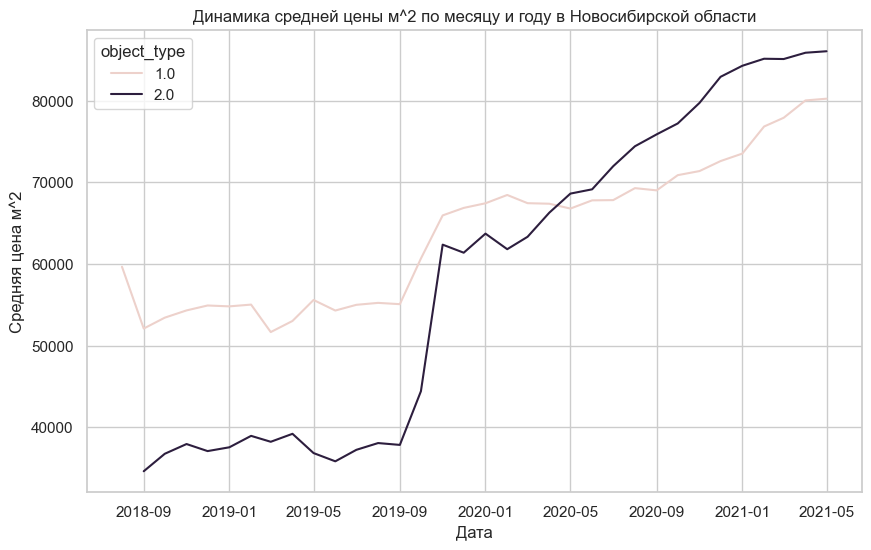

In [53]:
#создадим сводную таблицу с данными о размере средней цены м^2 по месяцу и году для Новосибирской области
df_year_month_mos = good_df[good_df['reg_name'] == 'Новосибирская область'].pivot_table(index=['month_year', 'object_type'], aggfunc='mean',values='price_1_m').sort_values (by = 'month_year', ascending=True).reset_index()
#построим линейный график по этой сводной таблице
sns.lineplot(data=df_year_month_mos, x='month_year', y='price_1_m', hue = 'object_type').set(title='Динамика средней цены м^2 по месяцу и году в Новосибирской области',
                                                                 xlabel='Дата', 
                                                                 ylabel='Средняя цена м^2')
plt.show()

Сравним динамику средней цены метра квадратного этого субъекта с общей динамикой по РФ. В Новосибирской области с сентября 2019 по май 2020 мы можем увидеть резкий скачок в стоимости м^2, в РФ это же происходило более сглажнно по понятным причнам, но все довольно заметно относительно других периодов, возможно, именно этот регион и внес большой вклад в формиование такой динамики на общероссийском рынке недвижимости, поскольку именно здесь было выставлено самое больше число объявлений. <br>

Кроме того, в данном регионе до введения льготной ипотеки разрыв между стоимостью новостройки и вторичного жилья был колоссальным, в мае 2020 (позже, чем во всей России) цены на новостройки обогнали вторичный рынок и высокими темпами продолжают расти. 

# 4. Определите от каких признаков зависит стоимость объекта недвижимости. Найдите скрытые закономерности.

In [38]:
#создадим словарь с месяцами-ключами и цифрами
good_df['month'] = good_df['month'].astype('str')
season_dict = {'1':'Зима',
          '2':'Зима',
          '12':'Зима',
          '3':'Весна',
          '4':'Весна',
          '5':'Весна',
          '6':'Лето',
          '7':'Лето',
          '8':'Лето',
          '9':'Осень',
          '10':'Осень',
          '11':'Осень'}
#применим словарь к сводной таблице
good_df['season'] = good_df['month'].map(season_dict)

In [39]:
#создадим словарь с месяцами-ключами и цифрами
good_df['month'] = good_df['month'].astype('str')
months_dict = {'1':'Январь',
          '2':'Февраль',
          '12':'Декабрь',
          '3':'Март',
          '4':'Апрель',
          '5':'Май',
          '6':'Июнь',
          '7':'Июль',
          '8':'Август',
          '9':'Сентябрь',
          '10':'Октябрь',
          '11':'Ноябрь'}
#применим словарь к сводной таблице
good_df['month_name'] = good_df['month'].map(months_dict)

In [40]:
good_df[['month', 'season']] = good_df[['month', 'season']].apply(lambda x: pd.factorize(x)[0])

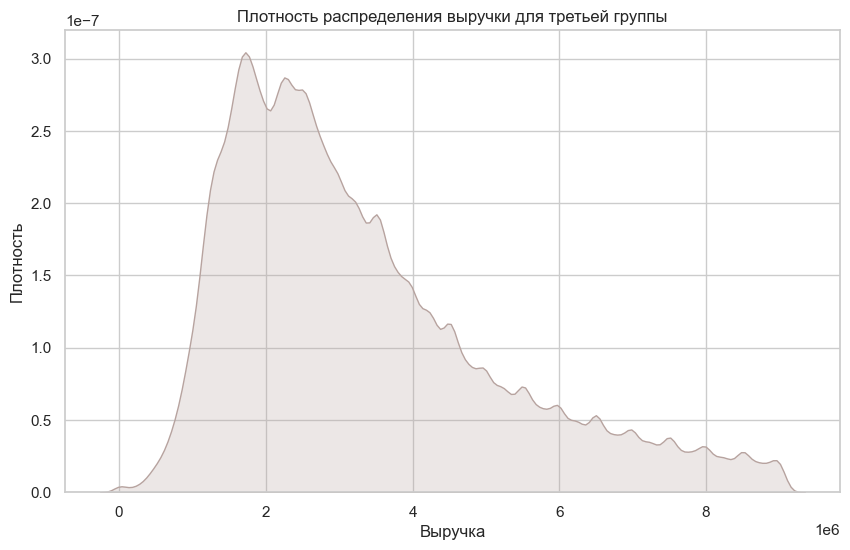

In [50]:
sns.kdeplot(good_df['price'], fill=True).set(title='Плотность распределения выручки для третьей группы',
                                                                 xlabel='Выручка', 
                                                                 ylabel='Плотность')
plt.show()

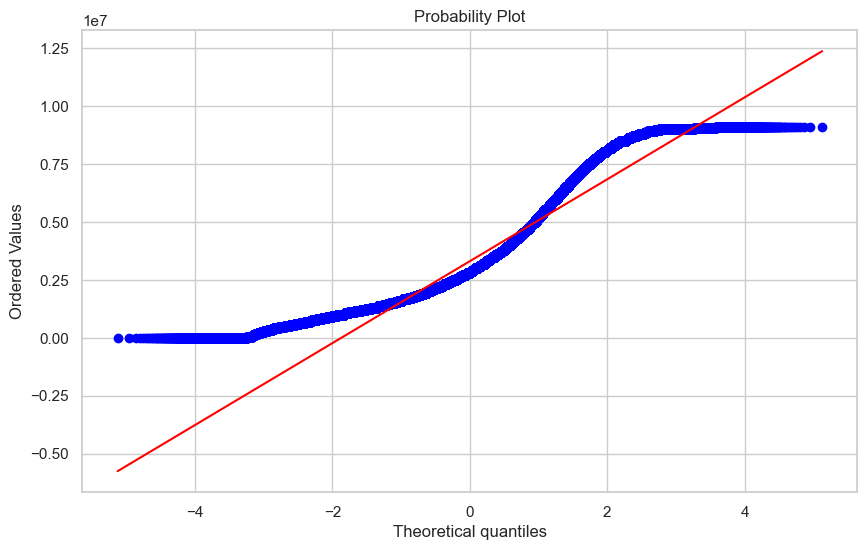

In [50]:
#построим Q-Q график
st.probplot(good_df['price'], dist='norm', plot=plt)
plt.show()

Как мы видим, распределение плотности стоимости квартир имеет ненормальный вид, поэтому для рассчета коэффициента корреляции нам необходимо использовать метод Спирмена, кроме того, он устойчив к выбросам.

In [51]:
df_corr = good_df.corr(method='spearman')
df_corr['price']

price            1.000000
region          -0.361960
building_type   -0.008467
level            0.255308
levels           0.379305
rooms            0.327110
area             0.441594
kitchen_area     0.406367
object_type      0.046532
year             0.182436
month           -0.022762
price_1_m        0.794075
season          -0.021274
Name: price, dtype: float64

<AxesSubplot:>

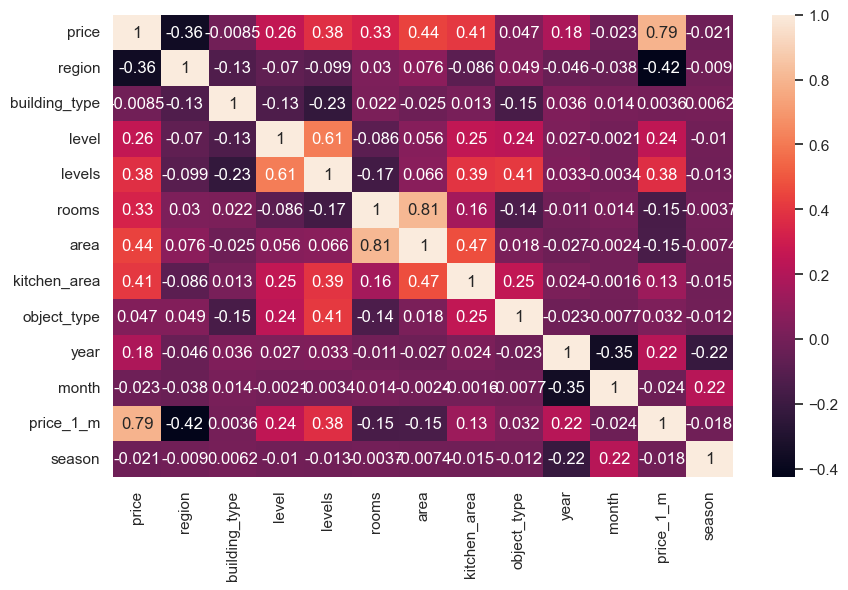

In [52]:
sns.heatmap(df_corr, annot=True)

Как и ожидалось, цена на квартиру больше всего коррелирует с ценой за квадратный метр (тесная связь и прямая по шкале Чеддока), умеренная и прямая свзь наблюдается с площаью всей кавартиры и площадью кухни. Посмотрим возможные скрытые законометрности. 

Существует гипотеза, что цены на квартиры с кухней больше 12 квадратов выше, чем в квартирах с маленькой кухней. <br>
Ho: цены на квартиры по площади кухни не отличаются <br>
H1: цены на квартиры по площади кухни отличаются <br>

Зафиксируем количество комнат, чтобы не было разброса в стоимости метра квадратного из-за количество комнат в квартире.

In [53]:
price_big = list(good_df[(good_df['rooms'] == 2) & (good_df['kitchen_area'] >= 12)]['price_1_m']) 
price_small = list(good_df[(good_df['rooms'] == 2) & (good_df['kitchen_area'] < 12)]['price_1_m']) 

In [54]:
np.mean(price_big)

73118.3042873639

In [55]:
np.mean(price_small)

63590.06333824606

In [85]:
#проведем непараметрический тест Уилкоксона-Манна-Уитни
alpha = 0.05
results = st.mannwhitneyu(price_big, price_small) 

print('p-value:', results.pvalue)

# формулируем результаты
if results.pvalue < alpha:
    print('Отклоянем нулевую гипотезу')
else:
    print('Нулевая гипотеза не отвергается')

p-value: 0.0
Отклоянем нулевую гипотезу


Значит, с вероятностью 95% цены на квартиры по площади кухни отличаются.

Существует гипотеза, что цена на кавадратный метр в малокомнатных квартирах дороже, чем в многокомнатных. <br>
Ho: цена на кавадратный метр в малокомнатных комнатах равна многокомнатному <br>
H1: цена на кавадратный метр в малокомнатных комнатах не равна многокомнатному <br>

In [86]:
price_big = list(good_df[(good_df['rooms'] > 2)]['price_1_m']) 
price_small = list(good_df[(good_df['rooms'] <= 2)]['price_1_m']) 

In [87]:
np.mean(price_big)

56443.99663538829

In [88]:
np.mean(price_small)

71909.37858154779

In [89]:
#проведем непараметрический тест Уилкоксона-Манна-Уитни
alpha = 0.05
results = st.mannwhitneyu(price_big, price_small) 

print('p-value:', results.pvalue)

# формулируем результаты
if results.pvalue < alpha:
    print('Отклоянем нулевую гипотезу')
else:
    print('Нулевая гипотеза не отвергается')

p-value: 0.0
Отклоянем нулевую гипотезу


С вероятностью 95% цена на кавадратный метр в малокомнатных комнатах больше многокомнатного

Существует гипотеза, что цена на квартиры, находящиеся на последнем и первом этажах ниже, чем на остальных.  <br>
Ho: цены на всех этажах одинаковые <br>
H1: цены на первом и последнем не равны ценам на остальных этажах  <br>

Зафиксируем количество комнат, чтобы не было разброса в стоимости метра квадратного из-за количество комнат в квартире. 

In [62]:
price_firt_last = list(good_df[(good_df['rooms'] == 1) & (good_df['levels'] == good_df['level'])]['price_1_m']) + list(good_df[(good_df['rooms'] == 1) & (good_df['level'] == 1)]['price_1_m'])
price_other = list(good_df[good_df['rooms'] == 1]['price_1_m'])

In [63]:
np.mean(price_firt_last)

62234.397525460394

In [64]:
np.mean(price_other)

74702.4520010758

In [65]:
#проведем непараметрический тест Уилкоксона-Манна-Уитни
alpha = 0.05
results = st.mannwhitneyu(price_firt_last, price_other) 

print('p-value:', results.pvalue)

# формулируем результаты
if results.pvalue < alpha:
    print('Отклоянем нулевую гипотезу')
else:
    print('Нулевая гипотеза не отвергается')

p-value: 0.0
Отклоянем нулевую гипотезу


Значит, с вероятностью 95% цены за квадратный метр на первом и последнем этажах в среднем ниже чем на остальных. 

Также существует гипотеза, что  цены на квартиры в новостройках на последнем этаже выше, чем не в новостройках на последнем. <br>
Ho: цены на последних этажах одинаковые для новостроек и не новостроек <br>
H1:  цены на последних этажах разные для новостроек и не новостроек <br>

In [66]:
price_last_new = list(good_df[(good_df['rooms'] == 1) & (good_df['levels'] == good_df['level']) & (good_df['object_type'] == 2)]['price_1_m']) 
price_last_old = list(good_df[(good_df['rooms'] == 1) & (good_df['levels'] == good_df['level']) & (good_df['object_type'] == 1)]['price_1_m'])

In [67]:
np.mean(price_last_new)

70328.4446562106

In [68]:
np.mean(price_last_old)

63202.10640967848

In [69]:
#проведем непараметрический тест Уилкоксона-Манна-Уитни
alpha = 0.05
results = st.mannwhitneyu(price_last_new, price_last_old) 

print('p-value:', results.pvalue)

# формулируем результаты
if results.pvalue < alpha:
    print('Отклоянем нулевую гипотезу')
else:
    print('Нулевая гипотеза не отвергается')

p-value: 0.00028589370899103614
Отклоянем нулевую гипотезу


Значит, с вероятностью 95% цены за квадратный метр на последнем этаже новостроек в среднем выше, чем на последних этажах неновостроек.

# 5. Когда выгодно покупать/продавать объект недвижимости?

In [41]:
#создадим словарь с месяцами-ключами и цифрами
good_df['month'] = good_df['month'].astype('str')
season_dict = {'1':'Зима',
          '2':'Зима',
          '12':'Зима',
          '3':'Весна',
          '4':'Весна',
          '5':'Весна',
          '6':'Лето',
          '7':'Лето',
          '8':'Лето',
          '9':'Осень',
          '10':'Осень',
          '11':'Осень'}
#применим словарь к сводной таблице
good_df['season'] = good_df['month'].map(season_dict)

In [42]:
#создадим словарь с месяцами-ключами и цифрами
good_df['month'] = good_df['month'].astype('str')
months_dict = {'1':'Январь',
          '2':'Февраль',
          '12':'Декабрь',
          '3':'Март',
          '4':'Апрель',
          '5':'Май',
          '6':'Июнь',
          '7':'Июль',
          '8':'Август',
          '9':'Сентябрь',
          '10':'Октябрь',
          '11':'Ноябрь'}
#применим словарь к сводной таблице
good_df['month_name'] = good_df['month'].map(months_dict)

In [43]:
good_df['season'].value_counts()

Осень    1214681
Лето     1178506
Зима      972505
Весна     960363
Name: season, dtype: int64

Мы видим, что быльше всего объявлений с предложениями о продаже было выложено осенью, меньше всего - весной. 

In [60]:
#создадим сводную таблицу с данными о размере средней стоимости квартир по сезонам
df_season = good_df.pivot_table(index='season', aggfunc='mean',values='price').sort_values (by = 'price', ascending=False).reset_index().head(10)
df_season['price'] = df_season['price'].astype('int')
df_season

,season,price
0,Зима,3465429
1,Осень,3299081
2,Лето,3235188
3,Весна,3219353


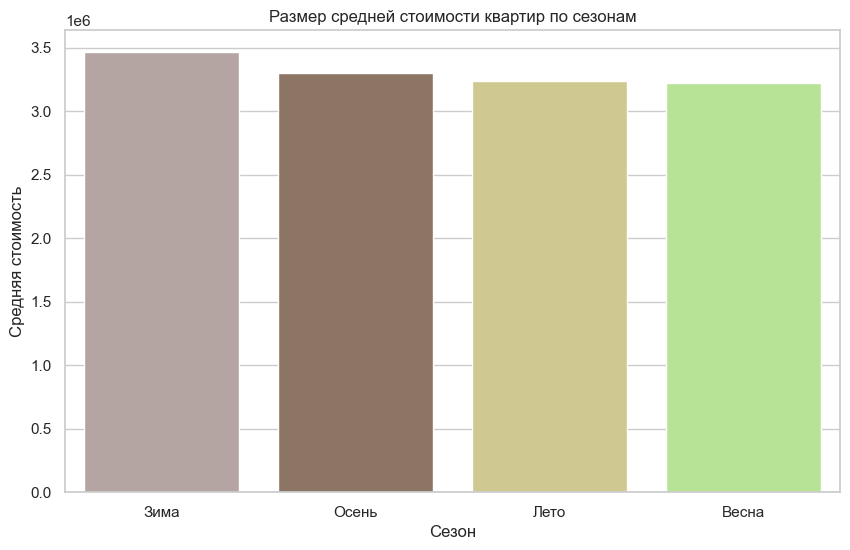

In [94]:
sns.barplot(data=df_season, y='price', x='season').set(title='Размер средней стоимости квартир по сезонам',
                                                                               ylabel='Средняя стоимость',
                                                                               xlabel='Сезон')
plt.show()

Таким образом, самая высокая средняя цена устанавливается на рынке зимой. Для более детального рассмотрения нам необходимо посмотреть на стоимость 1 м^2 в разные периоды, так как квартиры быввают разных площадей, для того чтобы данные были более сопоставимы лучше смотреть на цену квадратного метра, а не на абсолютное значение стоимости квартиры.  

In [44]:
mu = good_df['price_1_m'].mean() # среднее значение
sigma = good_df['price_1_m'].std() # стандартное отклонение
# рассчитваем значение правого уса
ej_h = mu + 3 * sigma
ej_l = mu - 3 * sigma
# выводим значение
print(ej_h, ej_l)

188493.57472543092 -50892.03296743495


In [45]:
good_df = good_df[( good_df['price_1_m'] < ej_h) & (good_df['price_1_m'] > ej_l)]
good_df = good_df.reset_index(drop=True)
good_df

,price,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date,reg_name,year,month,month_year,price_1_m,season,month_name
0,6050000.0,2661.0,1.0,8.0,10.0,3.0,82.6,10.8,1.0,2018-02-19,Санкт-Петербург,2018,0,2018-02-01,73244.55,NaN,NaN
1,3600000.0,2661.0,1.0,2.0,5.0,1.0,31.1,6.0,1.0,2018-03-04,Санкт-Петербург,2018,1,2018-03-01,115755.63,Зима,Январь
2,3200000.0,2661.0,1.0,7.0,9.0,1.0,31.0,7.0,1.0,2018-04-10,Санкт-Петербург,2018,2,2018-04-01,103225.81,Зима,Февраль
3,6500000.0,2661.0,3.0,3.0,3.0,3.0,89.0,10.0,1.0,2018-04-23,Санкт-Петербург,2018,2,2018-04-01,73033.71,Зима,Февраль
4,6300000.0,2661.0,3.0,5.0,5.0,2.0,99.9,14.5,1.0,2018-04-28,Санкт-Петербург,2018,2,2018-04-01,63063.06,Зима,Февраль
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4662786,3000000.0,61888.0,5.0,2.0,2.0,2.0,57.0,10.0,1.0,2018-11-29,Ненецкий автономный округ,2018,9,2018-11-01,52631.58,Осень,Сентябрь
4662787,1400000.0,61888.0,3.0,3.0,3.0,1.0,18.6,4.0,1.0,2018-11-29,Ненецкий автономный округ,2018,9,2018-11-01,75268.82,Осень,Сентябрь
4662788,6000000.0,61888.0,3.0,5.0,5.0,2.0,64.3,16.3,1.0,2018-11-30,Ненецкий автономный округ,2018,9,2018-11-01,93312.60,Осень,Сентябрь
4662789,3500000.0,61888.0,2.0,1.0,3.0,2.0,59.7,10.2,1.0,2018-11-30,Ненецкий автономный округ,2018,9,2018-11-01,58626.47,Осень,Сентябрь


In [97]:
#создадим сводную таблицу с данными о размере средней стоимости 1 м^2 по сезонам
df_season_1 = good_df.pivot_table(index='season', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=False).reset_index().head(10)
df_season_1

,season,price_1_m
0,Зима,68873.540536
1,Осень,65640.729856
2,Лето,64779.117519
3,Весна,64579.330618


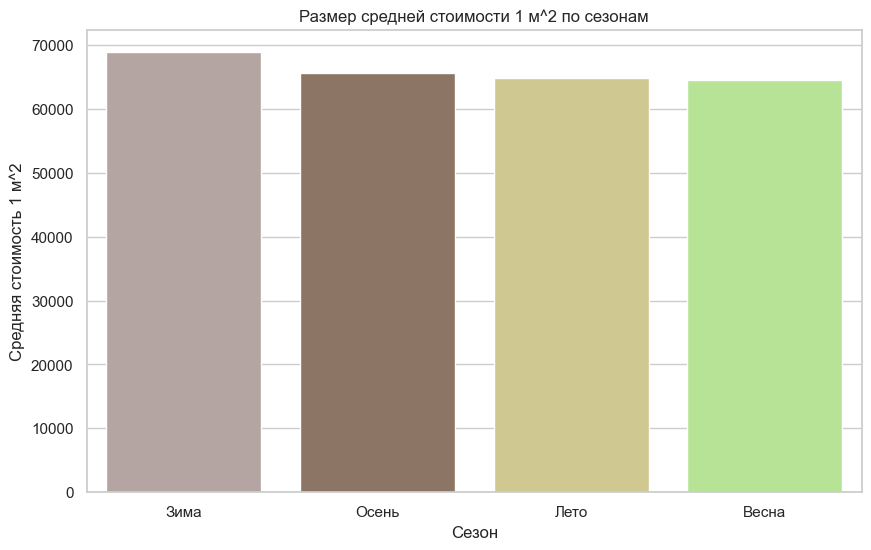

In [69]:
#построим столбчатую диаграмму по данной таблице
sns.barplot(data=df_season_1, y='price_1_m', x='season').set(title='Размер средней стоимости 1 м^2 по сезонам',
                                                                               ylabel='Средняя стоимость 1 м^2',
                                                                               xlabel='Сезон')
plt.show()

Таким образом, самая высокая средняя цена устанавливается на рынке зимой. В целом положение времен года не изменилось, но разброс в стоимостях между ними сократился, поскольку мы рассматриваем относительный показатель. Цена весеой и летом кажется мне не сильно отличающейся друг от друга, проверим это статистической гипотезой. 

Проверим следующие гипотезы: <br>
H0: средние цены 1 м^2 летом и весной равны друг другу <br>
H1: средние цены 1 м^2 летом и весной не равны друг другу

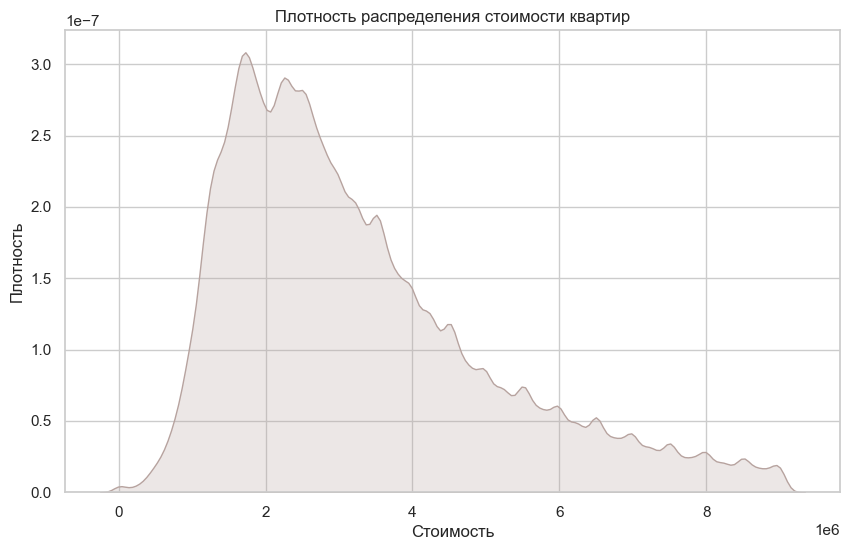

In [77]:
sns.kdeplot(good_df['price'], fill=True).set(title='Плотность распределения стоимости квартир',
                                                                 xlabel='Стоимость', 
                                                                 ylabel='Плотность')
plt.show()

In [96]:
#создадим два списка с данными по стоимости за осень и зиму
summer = list(good_df[good_df['season'] == 'Лето']['price_1_m'])
spring = list(good_df[good_df['season'] == 'Весна']['price_1_m'])

Распределение стоимости квартир, как и ожидалось, имеет ненормальный вид, поэтому для провнрки данной гипотезы нужно использовать непараметрический тест Манна-уитни. 

In [97]:
#проведем непараметрический тест Уилкоксона-Манна-Уитни
alpha = 0.05
results = st.mannwhitneyu(summer, spring) 

print('p-value:', results.pvalue)

# формулируем результаты
if results.pvalue < alpha:
    print('Отклоянем нулевую гипотезу')
else:
    print('Нулевая гипотеза не отвергается')

p-value: 4.600734617852431e-18
Отклоянем нулевую гипотезу


Таким образом, с вероятностью 0,95 средняя стоимость квартир в весенний и летний периоды не равны друг другу. Значит, мое предположение было ошибочным, и эти значия значительно отличаются друг от друга. 

Теперь хочу вернуться к рассмотрению отдельно двух регионов, по которым было большее число объявлений - это Санкт-Петербург и Новосибирская область. 

In [98]:
#создадим сводную таблицу с данными о размере средней цене 1 м^2 в Санкт-Петербурге по сезонам 
df_season_2 = good_df[good_df['reg_name'] == 'Санкт-Петербург'].pivot_table(index='season', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=False).reset_index().head(10)
df_season_2

,season,price_1_m
0,Зима,121423.220884
1,Весна,114552.379568
2,Осень,112891.719876
3,Лето,112575.178411


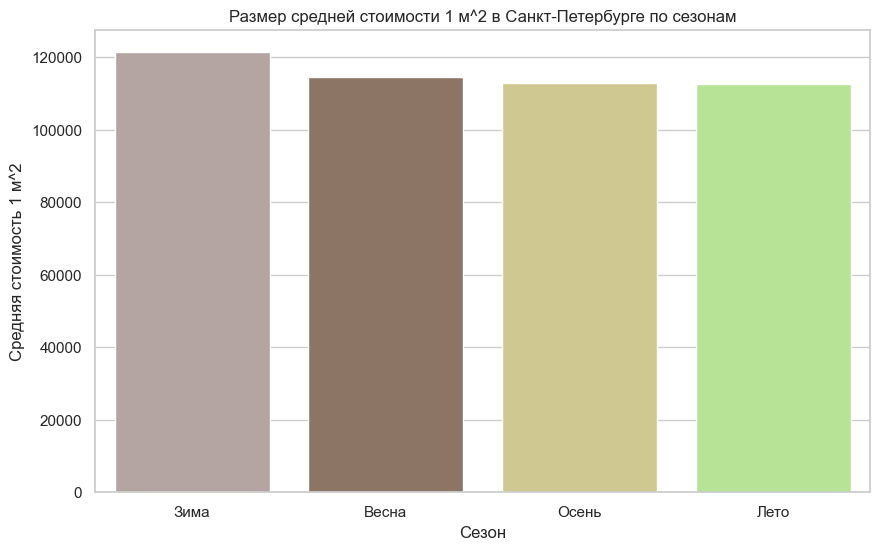

In [74]:
#построим столбчатую диаграмму по данной таблице
sns.barplot(data=df_season_2, y='price_1_m', x='season').set(title='Размер средней стоимости 1 м^2 в Санкт-Петербурге по сезонам',
                                                                               ylabel='Средняя стоимость 1 м^2',
                                                                               xlabel='Сезон')
plt.show()

Как мы видим, зимой цены на недвижимость в Петербурге самые высокие, как и во всей России, однако, самые низкие не весной, а летом. Кроме того, очевидно, что в целом уровень цен в городе выше общероссийского. 

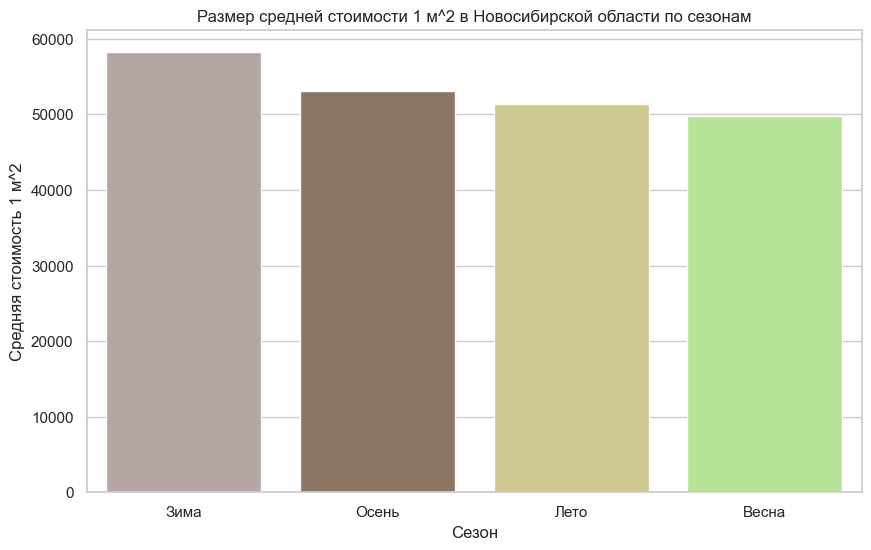

In [75]:
sns.barplot(data=good_df[good_df['reg_name'] == 'Новосибирская область'].pivot_table(index='season', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=False).reset_index(), y='price_1_m', x='season').set(title='Размер средней стоимости 1 м^2 в Новосибирской области по сезонам',
                                                                               ylabel='Средняя стоимость 1 м^2',
                                                                               xlabel='Сезон')
plt.show()

Как мы видим, цены на недвижимость в Новосибирской области полностью соответствуют положению на общероссийском рынке. Кроме того, очевидно, что в целом уровень цен в регионе ниже общероссийского.

In [99]:
df_old = good_df[good_df['object_type'] == 1].pivot_table(index='season', aggfunc='mean',values='price_1_m').reset_index()
df_new = good_df[good_df['object_type'] == 2].pivot_table(index='season', aggfunc='mean',values='price_1_m').reset_index()
df_old['price_1_m_new'] = df_new['price_1_m']
df_old

,season,price_1_m,price_1_m_new
0,Весна,63843.308319,66498.226717
1,Зима,67171.197257,73311.251685
2,Лето,64219.721842,66355.655993
3,Осень,63245.784455,72071.268122


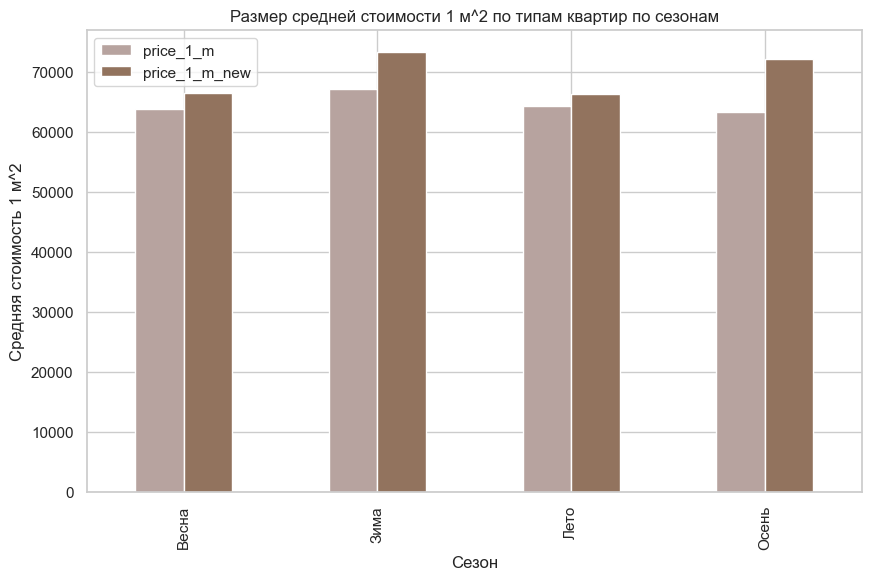

In [77]:
df_old[['season', 'price_1_m', 'price_1_m_new']].plot(x='season', kind='bar').set(title='Размер средней стоимости 1 м^2 по типам квартир по сезонам',
                                                                               ylabel='Средняя стоимость 1 м^2',
                                                                               xlabel='Сезон')
plt.show()

Напомню: 1 - Вторичный рынок; 2 - Новостройка. <br>
Как мы видим по всем временам года цены на первичном рынке, выше чем, на вторичном. Летом самые низкие цены на обоих рынках, зимой, как и говорилось ранее - самые высокие. 


Теперь посмотрим на ситуацию еще глубже, укрупнив сезоны по месяцам.

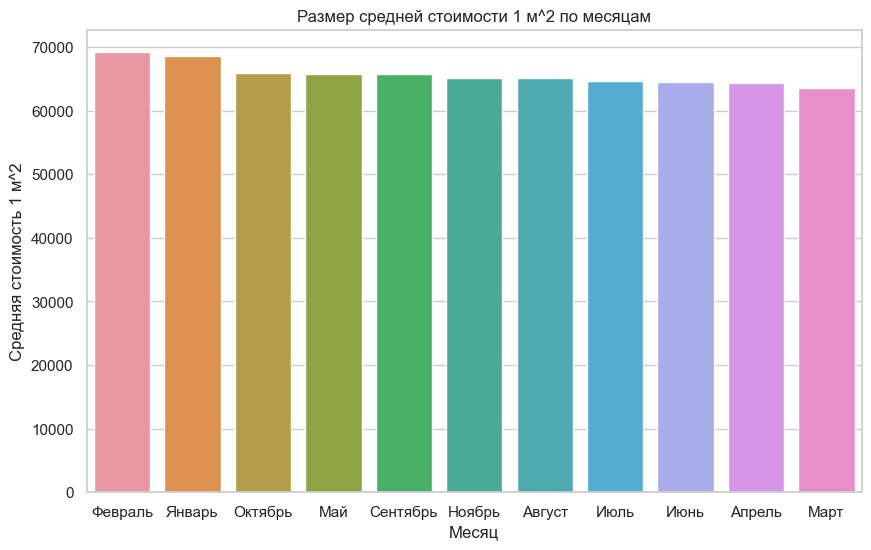

In [78]:
sns.barplot(data=good_df.pivot_table(index='month_name', aggfunc='mean',values='price_1_m').sort_values (by = 'price_1_m', ascending=False).reset_index(), y='price_1_m', x='month_name').set(title='Размер средней стоимости 1 м^2 по месяцам',
                                                                               ylabel='Средняя стоимость 1 м^2',
                                                                               xlabel='Месяц')
plt.show()

Таким образом, самый дорогой квадратный метр в феврале, а самый дешевый в марте.  Теперь посмотрим что происходит на отдельных рынках вторичного и первичного жилья. 

In [79]:
df_old = good_df[good_df['object_type'] == 1].pivot_table(index='month_name', aggfunc='mean',values='price_1_m').reset_index()
df_new = good_df[good_df['object_type'] == 2].pivot_table(index='month_name', aggfunc='mean',values='price_1_m').reset_index()
df_old['price_1_m_new'] = df_new['price_1_m']
df_ild = df_old.sort_values(['price_1_m','price_1_m_new'], ascending=[False, False])
df_old

,month_name,price_1_m,price_1_m_new
0,Август,63890.706384,68414.930644
1,Апрель,63679.955982,65835.213187
2,Июль,64492.998527,65146.143606
3,Июнь,64314.533255,64781.904134
4,Май,64287.700323,69804.648366
5,Март,63453.262529,63669.098784
6,Ноябрь,63938.224930,68595.781525
7,Октябрь,61805.177821,76459.791360
8,Сентябрь,64165.118263,69856.047304
9,Февраль,67851.935152,72715.392357


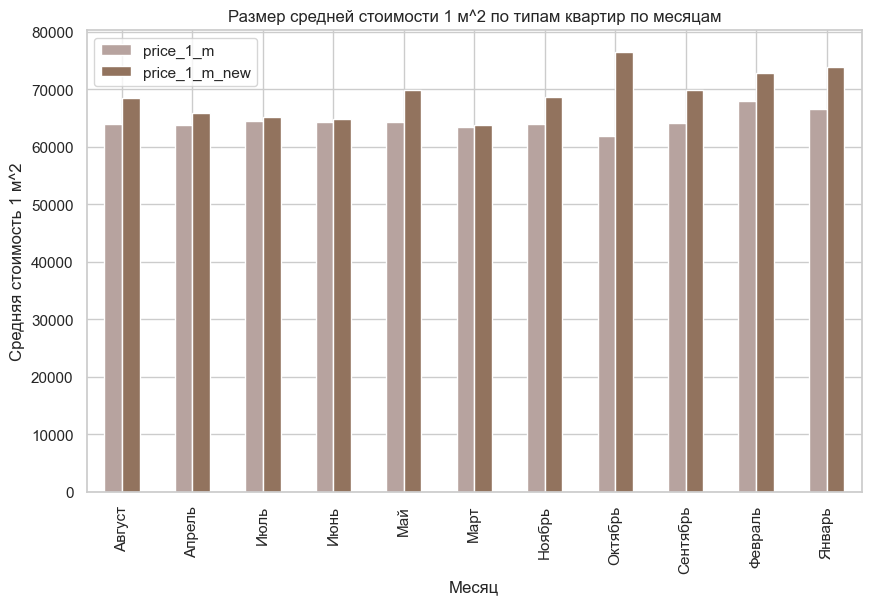

In [80]:
df_old[['month_name', 'price_1_m', 'price_1_m_new']].plot(x='month_name', kind='bar').set(title='Размер средней стоимости 1 м^2 по типам квартир по месяцам',
                                                                               ylabel='Средняя стоимость 1 м^2',
                                                                               xlabel='Месяц')
plt.show()

Самая низкая цена на новостройки в марте, а самая высокая - в октябре, январе. <br>
Самая низкая цена на вторичное жилье в октябре, а самая высокая - в феврале, январе. 

Когда же выгоднее покупать жилье в Петербурге?

In [81]:
df_old = good_df[(good_df['object_type'] == 1) & (good_df['reg_name'] == 'Санкт-Петербург')].pivot_table(index='month_name', aggfunc='mean',values='price_1_m').reset_index()
df_new = good_df[(good_df['object_type'] == 2) & (good_df['reg_name'] == 'Санкт-Петербург')].pivot_table(index='month_name', aggfunc='mean',values='price_1_m').reset_index()
df_old['price_1_m_new'] = df_new['price_1_m']
df_ild = df_old.sort_values(['price_1_m','price_1_m_new'], ascending=[False, False])
df_old

,month_name,price_1_m,price_1_m_new
0,Август,111699.064465,114146.807793
1,Апрель,114049.290201,112509.997956
2,Июль,110979.003919,112051.266491
3,Июнь,116018.801723,113406.043070
4,Май,115739.803899,115975.250691
5,Март,114017.709546,114576.887838
6,Ноябрь,113347.442158,113719.187915
7,Октябрь,112624.955378,113161.513945
8,Сентябрь,112065.649408,113118.801529
9,Февраль,123876.672313,123488.860255


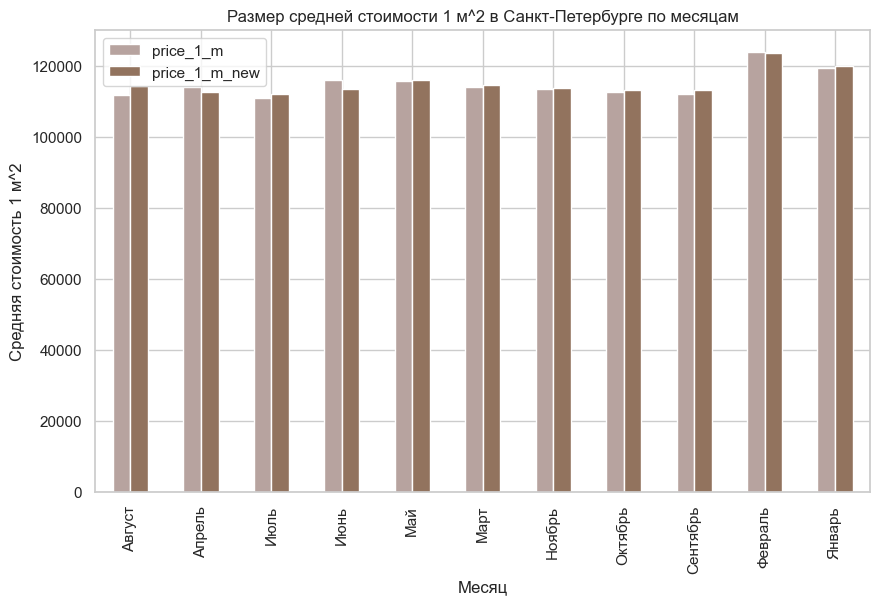

In [82]:
df_old[['month_name', 'price_1_m', 'price_1_m_new']].plot(x='month_name', kind='bar').set(title='Размер средней стоимости 1 м^2 в Санкт-Петербурге по месяцам',
                                                                               ylabel='Средняя стоимость 1 м^2',
                                                                               xlabel='Месяц')
plt.show()

Самая низкая цена на вторичное жилье в июле, агусте, а самая высокая - в феврале <br>
Самая низкая цена на новостройки в июле, а самая высокая - в феврале <br>

Кроме того, можно заметить, что в июне цены на вторичку оказывались выше, чем на новые объекты недвижимости. В целом, в Петербурге можно увидеть, что разброс между ценами квадратного метра но вторичное и первичное жилье не такой большой. 

Выводы: <br>
    1. Выгоднее всего в общем виде квартиры покупать весной (март) или летом (июнь), а продавать зимой (февраль, январь) или осенью (октябрь). <br>
    2. Выгоднее всего покупать первичное жилье весной (март), а продавать зимой (январь) или осенью (октябрь).<br>
    3. Выгоднее всего покупать вторичное жилье в октябре, а продавать в январе, феврале. <br>
    4. Выгоднее всего покупать первичное жилье в Санкт-Петербурге в июле, а продавать в январе, феврале.<br>
    5. Выгоднее всего покупать вторичное жилье в Санкт-Петербурге в июле или августе, а продавать в феврале. <br>

# 6. Создайте модель прогноза цены объекта недвижимости

In [46]:
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV

Достаточно сложно вывести универсальную модель для всех регионов. Ведь этот фактор тоже достаточно сильно влияет на стоимость нежвижимости, поэтому она в разных регионах может отличаться в несколько раз, в чем мы собственно и убедились на примере Новосибирской области и Санкт-Петербурга. <br> 

Попытаюсь разработать модель ценообразованияза 2021 год для квартир, расположенных в Санкт-Петербурге.

In [47]:
good_df_1 = good_df[(good_df['year'] == 2021) & (good_df['reg_name'] == 'Санкт-Петербург')]

In [48]:
# раздяем данные на признаки
x = good_df_1[['area', 'kitchen_area', 'levels']]
y = good_df_1['price']

In [49]:
#разделяем данные на обучающую и валидационную выборку с random_state=13
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13) 

In [50]:
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)

In [51]:
# Используем «стандартизатор» для тестовой выборки
x_test_st = scaler.transform(x_test)

In [52]:
# создадим модель линейной регрессии
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
 
# создадим объект этого класса и запишем в переменную model
model_1 = Lasso()

# обучим нашу модель
model_1.fit(x_train_st, y_train)

# напечатаем коэффициенты
print(model_1.coef_, model_1.intercept_)

[1121533.97413222  219510.01798903  147878.45061789] 5989872.906337679


Уравнение регресии: у = 5989872.9+ 1661447.30х1 + 82692.99х2 + 1076257.68х3 - 24348.10х4 <br>
y - стоимость квартиры <br>
x1 - площадь квартиры <br>
x2 - площадь кухни <br>
х3 - количество этажей в доме

In [53]:
# делаем прогнозы
predictions = model_1.predict(x_test_st)

In [54]:
# проверяем r2
from sklearn.metrics import  mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
r2_score(y_test,predictions)

0.5933025700945381

59,3% вариации цены на квартиру определяетс явариацией ее площади, площади кухни и цены за 1 м^2

C:\Users\Настя\AppData\Local\Temp\ipykernel_29752\3992461598.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')


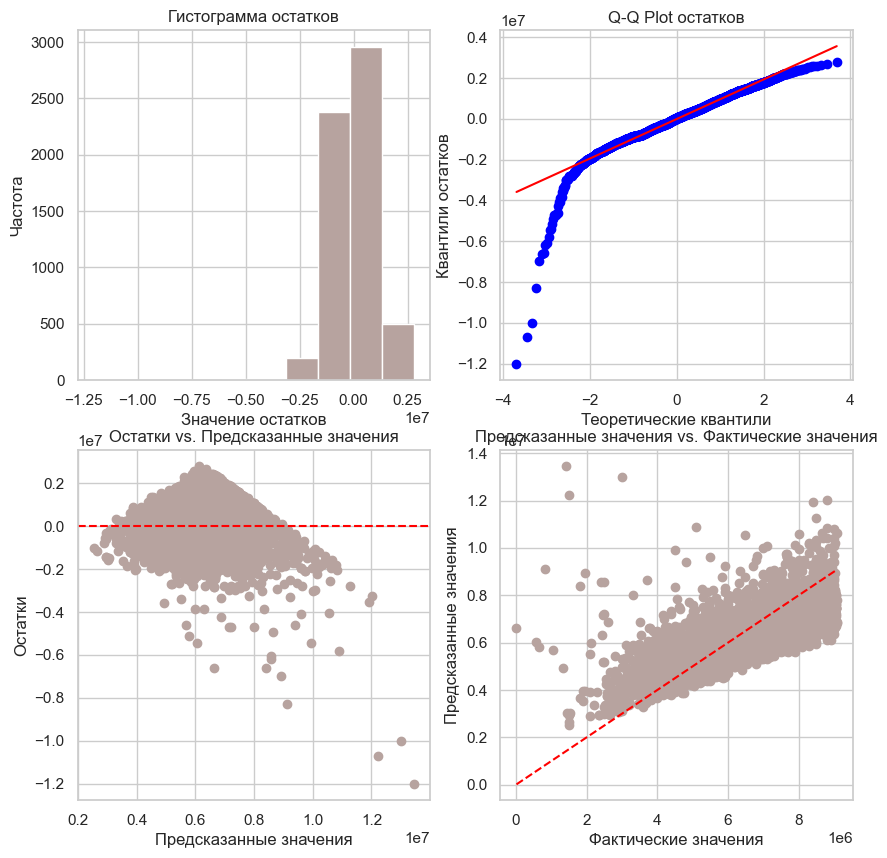

In [55]:
import statsmodels.api as sm

# Получение остатков модели
residuals = y_test - predictions

# Расчет стандартизированных остатков
stand_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
plt.subplots(figsize=(10, 10))


# Распределение остатков
plt.subplot(2, 2, 1)
plt.hist(residuals)
plt.xlabel('Значение остатков')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.grid(True)


# График остатков vs. предсказанных значений
plt.subplot(2, 2, 2)
st.probplot(residuals, dist='norm', plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Квантили остатков')
plt.title('Q-Q Plot остатков')
plt.grid(True)

#График остатков относительно прогноза
plt.subplot(2, 2, 3)
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs. Предсказанные значения')

# Предсказанные и фактические значения
plt.subplot(2, 2, 4)
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения vs. Фактические значения')
plt.show()

In [56]:
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

In [57]:
print("Среднеквадратическая ошибка (MSE):", mse)
print("Среднеквадратическая ошибка (RMSE):", rmse)
print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя абсолютная ошибка  (MAPE):", mape)

Среднеквадратическая ошибка (MSE): 998443295900.8303
Среднеквадратическая ошибка (RMSE): 999221.3447984537
Средняя абсолютная ошибка (MAE): 755304.9819148942
Средняя абсолютная ошибка  (MAPE): 0.21809593159390514


Несмотря на отличную детерминацию, модель крайне низкого качества, поскольку видна очевидная гетероскедастичность остатков от фактров, включенных в модель регрессии, кроме того остатки распределены крайне ненормально. По этим причнам использовать данную модель для прогоноза не целесообразно, так как она будет давать нам огромные ошибки (низкая точность модели). 

Для построения другой модели предсказания цены на квартиру попробуем использовать  другие методы, а именно машинное обучение - градиентный бустинг методом XGBoost.

In [58]:
!pip install xgboost
import xgboost as xgb

In [59]:
good_df_1 = good_df[(good_df['year'] == 2021) & (good_df['reg_name'] == 'Санкт-Петербург')]

In [60]:
# раздяем данные на признаки
x = good_df_1[['area', 'kitchen_area', 'levels']]
y = good_df_1['price']

In [61]:
#разделяем данные на обучающую и валидационную выборку с random_state=13
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13) 

In [62]:
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)

In [63]:
# Используем «стандартизатор» для тестовой выборки
x_test_st = scaler.transform(x_test)

In [64]:
model = xgb.XGBRegressor()
model.fit(x_train_st, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [65]:
predictions = model.predict(x_test_st)

In [66]:
# проверяем r2
from sklearn.metrics import  mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
r2_score(y_test,predictions)

0.7354846221647093

In [67]:
from sklearn.metrics import  mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [68]:
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

In [69]:
print("Среднеквадратическая ошибка (MSE):", mse)
print("Среднеквадратическая ошибка (RMSE):", rmse)
print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя абсолютная ошибка  (MAPE):", mape)

Среднеквадратическая ошибка (MSE): 649385971590.0167
Среднеквадратическая ошибка (RMSE): 805844.8806004892
Средняя абсолютная ошибка (MAE): 555063.0715552805
Средняя абсолютная ошибка  (MAPE): 0.1904700349960895


C:\Users\Настя\AppData\Local\Temp\ipykernel_29752\3992461598.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')


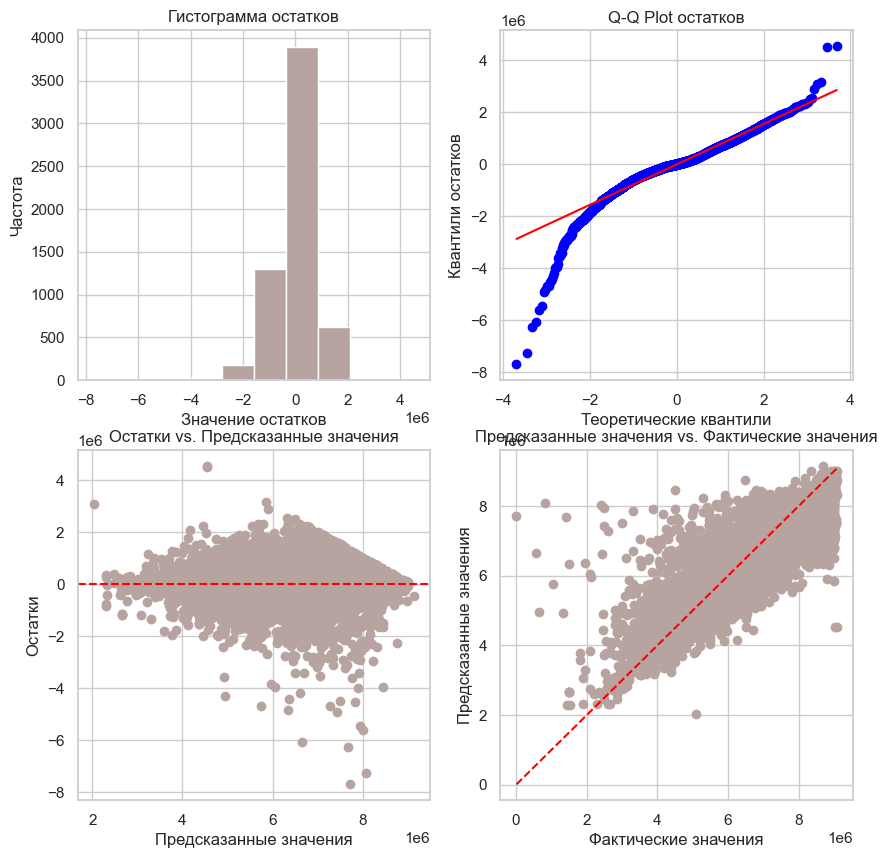

In [70]:
import statsmodels.api as sm

# Получение остатков модели
residuals = y_test - predictions

# Расчет стандартизированных остатков
stand_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
plt.subplots(figsize=(10, 10))


# Распределение остатков
plt.subplot(2, 2, 1)
plt.hist(residuals)
plt.xlabel('Значение остатков')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.grid(True)


# График остатков vs. предсказанных значений
plt.subplot(2, 2, 2)
st.probplot(residuals, dist='norm', plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Квантили остатков')
plt.title('Q-Q Plot остатков')
plt.grid(True)

#График остатков относительно прогноза
plt.subplot(2, 2, 3)
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs. Предсказанные значения')

# Предсказанные и фактические значения
plt.subplot(2, 2, 4)
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения vs. Фактические значения')
plt.show()

По модели градиентного бустинга ошибки прогноза меньше, к тому же остатки распределены более равномерно, прогнозные значения и фактические значения более плотно уложены в линию регрессии, хотя гетероскедастичность остатков все равно останется в нашей прогнозной модели. 

Подведем итоги работы: <br>

1. Мною были обработаны данные: удалены дубликаты и выбросы по определенным категориям, изменены типы данных, изменены опечатки в данных типа отрацительной стоимости кавартир, количества, комнат равного -2. Также были заполнены пропущенные значения в стобце kitchen_area с помощью метода mice. <br>
<br>
2. Был присоединен датасет с регионами, который прежде был обработан на возможные ошибки и описки в данных. <br>
<br>
3. Был исследован рынок недвижимости в РФ за представленный период, были рассомотрены динамики м^2 по типам квартир, по типам домов, по регионам, по количеству квартир в доме и тд. <br>
<br>
4. Скрытые закономерности показали, что квартиры на последних этажак в новостройках дороже, чем квартиры на последних этажах в неновостройках, также кавартиры на первом и посленем этажах обычно дешевле, чем на остальных, также цена на кавадратный метр в малокомнатных квартирах дороже, чем в многокомнатных. <br>
<br>
5. Исседование сезонности показало, что: 
    1. Выгоднее всего в общем виде квартиры покупать весной (март) или летом (июнь), а продавать зимой (февраль, январь) или осенью (октябрь). <br>
    2. Выгоднее всего покупать первичное жилье весной (март), а продавать зимой (январь) или осенью (октябрь).<br>
    3. Выгоднее всего покупать вторичное жилье в октябре, а продавать в январе, феврале. <br>
    4. Выгоднее всего покупать первичное жилье в Санкт-Петербурге в июле, а продавать в январе, феврале.<br>
    5. Выгоднее всего покупать вторичное жилье в Санкт-Петербурге в июле или августе, а продавать в феврале. <br>
<br>
6. Было построено две модели регрессии (с помощью линейнной регресси и градиентного бустинга), детерминация по обеим оказалась очень хорошей, но распределение остатков лучше во второй модели, хотя они все равно распределены ненормально, что естественно в этой ситуации, к тому же ошибки прогноза по этой модели ниже. 